# Import Dependencies

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install some optional requirements
# !pip install -r requirements/optional.txt

In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
import decord
import pickle

1.7.0+cu110 True
0.12.0
11.0
GCC 7.5


In [4]:
# cd

/home/actrec/.virtualenvs/mmaction/mmaction2


In [1]:
pwd

'/media/actrec/DATA/.virtualenvs/mmaction/mmaction2'

In [2]:
ls

checkpoints/           LICENSE*                requirements.txt*
childact-checkpoints/  mmaction/               setup.cfg*
configs/               mmaction2.egg-info/     setup.py*
data/                  mmaction-adults.ipynb*  tests/
demo/                  my-mmaction.ipynb*      tools/
docker/                README.md*              untitled.txt*
docs/                  README_zh-CN.md*
docs_zh_CN/            requirements/


# CSN no kinetics pretrain

In [8]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/csn/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb.py')

In [9]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-no-transfer'

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


cfg.val_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=32,
        frame_interval=2,
        num_clips=1,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5)
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.test_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=10, test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]



cfg.train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=1),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
#     dict(type='RandomCrop', size=224),
    dict(type='RandomResizedCrop'),
    dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

# cfg.lr_config = dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-5),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

cfg.total_epochs = 100

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=8

cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=False,
        zero_init_residual=False,
        in_channels=2),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'
img_norm_cfg = dict(me

In [10]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-05-08 08:07:16,744 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-05-08 08:07:16,745 - mmaction - INFO - Use load_from_http loader
2021-05-08 08:07:16,897 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for conv1.conv.weight: copying a param with shape torch.Size([64, 3, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 3, 7, 7]).
2021-05-08 08:07:16,976 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /media/actrec/DATA/.virtualenvs/mmaction/mmaction2/childact-checkpoints/CSN-no-transfer
2021-05-08 08:07:16,977 - mmaction - INFO - workflow: [('train', 1)], max: 100 epochs
2021-05-08 08:10:37,386 - mmaction - INFO - Epoch [1][100/132]	lr: 1.777e-05, eta: 7:17:32, time: 2.004, data_time: 0.030, memory: 21787, top1_acc: 0.1562, top5_acc: 0.7050, loss_cls: 1.9500, loss: 1.9500,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.2 task/s, elapsed: 8s, ETA:     0s

2021-05-08 08:29:30,214 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 08:29:30,215 - mmaction - INFO - 
top1_acc	0.7063
top5_acc	1.0000
2021-05-08 08:29:30,216 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 08:29:30,218 - mmaction - INFO - 
mean_acc	0.7063
2021-05-08 08:29:32,233 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-05-08 08:29:32,235 - mmaction - INFO - Best top1_acc is 0.7063 at 5 epoch.
2021-05-08 08:29:32,236 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.7063, top5_acc: 1.0000, mean_class_accuracy: 0.7063
2021-05-08 08:32:57,711 - mmaction - INFO - Epoch [6][100/132]	lr: 5.293e-05, eta: 5:31:42, time: 2.055, data_time: 0.037, memory: 21787, top1_acc: 0.5613, top5_acc: 0.9525, loss_cls: 1.4477, loss: 1.4477, grad_norm: 13.0017
2021-05-08 08:37:21,040 - mmaction - INFO - Epoch [7][100/132]	lr: 5.996e-05, eta: 5:25:42, time: 2.004, data_time: 0.030, memory: 21787, top1_acc: 0.6075, top5_acc: 0.9587,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.8 task/s, elapsed: 7s, ETA:     0s

2021-05-08 08:51:38,717 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 08:51:38,718 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	0.9841
2021-05-08 08:51:38,719 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 08:51:38,719 - mmaction - INFO - 
mean_acc	0.8095
2021-05-08 08:51:40,646 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-05-08 08:51:40,647 - mmaction - INFO - Best top1_acc is 0.8095 at 10 epoch.
2021-05-08 08:51:40,648 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.8095, top5_acc: 0.9841, mean_class_accuracy: 0.8095
2021-05-08 08:55:06,553 - mmaction - INFO - Epoch [11][100/132]	lr: 8.809e-05, eta: 5:07:28, time: 2.059, data_time: 0.041, memory: 21787, top1_acc: 0.7050, top5_acc: 0.9675, loss_cls: 0.8715, loss: 0.8715, grad_norm: 18.8563
2021-05-08 08:59:30,429 - mmaction - INFO - Epoch [12][100/132]	lr: 9.512e-05, eta: 5:03:20, time: 2.012, data_time: 0.032, memory: 21787, top1_acc: 0.6825, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-05-08 09:13:48,515 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 09:13:48,517 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	0.9921
2021-05-08 09:13:48,518 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 09:13:48,519 - mmaction - INFO - 
mean_acc	0.8413
2021-05-08 09:13:50,626 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-05-08 09:13:50,627 - mmaction - INFO - Best top1_acc is 0.8413 at 15 epoch.
2021-05-08 09:13:50,628 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.8413, top5_acc: 0.9921, mean_class_accuracy: 0.8413
2021-05-08 09:17:16,281 - mmaction - INFO - Epoch [16][100/132]	lr: 1.232e-04, eta: 4:47:53, time: 2.056, data_time: 0.042, memory: 21787, top1_acc: 0.7137, top5_acc: 0.9663, loss_cls: 0.7664, loss: 0.7664, grad_norm: 19.2321
2021-05-08 09:21:38,477 - mmaction - INFO - Epoch [17][100/132]	lr: 1.250e-04, eta: 4:44:04, time: 2.002, data_time: 0.031, memory: 21787, top1_acc: 0.7175, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.8 task/s, elapsed: 19s, ETA:     0s

2021-05-08 09:36:03,103 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 09:36:03,105 - mmaction - INFO - 
top1_acc	0.8889
top5_acc	0.9921
2021-05-08 09:36:03,106 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 09:36:03,107 - mmaction - INFO - 
mean_acc	0.8889
2021-05-08 09:36:05,308 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-05-08 09:36:05,309 - mmaction - INFO - Best top1_acc is 0.8889 at 20 epoch.
2021-05-08 09:36:05,309 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.8889, top5_acc: 0.9921, mean_class_accuracy: 0.8889
2021-05-08 09:39:33,771 - mmaction - INFO - Epoch [21][100/132]	lr: 1.250e-04, eta: 4:29:31, time: 2.085, data_time: 0.034, memory: 21787, top1_acc: 0.7388, top5_acc: 0.9700, loss_cls: 0.7396, loss: 0.7396, grad_norm: 21.6458
2021-05-08 09:44:00,076 - mmaction - INFO - Epoch [22][100/132]	lr: 1.250e-04, eta: 4:26:08, time: 2.044, data_time: 0.035, memory: 21787, top1_acc: 0.7288, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.4 task/s, elapsed: 7s, ETA:     0s

2021-05-08 09:58:20,406 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 09:58:20,407 - mmaction - INFO - 
top1_acc	0.9127
top5_acc	0.9921
2021-05-08 09:58:20,408 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 09:58:20,408 - mmaction - INFO - 
mean_acc	0.9127
2021-05-08 09:58:22,588 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2021-05-08 09:58:22,590 - mmaction - INFO - Best top1_acc is 0.9127 at 25 epoch.
2021-05-08 09:58:22,591 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.9127, top5_acc: 0.9921, mean_class_accuracy: 0.9127
2021-05-08 10:01:46,704 - mmaction - INFO - Epoch [26][100/132]	lr: 1.250e-04, eta: 4:12:05, time: 2.041, data_time: 0.031, memory: 21787, top1_acc: 0.7325, top5_acc: 0.9875, loss_cls: 0.6694, loss: 0.6694, grad_norm: 20.3484
2021-05-08 10:06:08,021 - mmaction - INFO - Epoch [27][100/132]	lr: 1.250e-04, eta: 4:08:28, time: 1.990, data_time: 0.032, memory: 21787, top1_acc: 0.7675, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.1 task/s, elapsed: 7s, ETA:     0s

2021-05-08 10:20:23,888 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 10:20:23,890 - mmaction - INFO - 
top1_acc	0.8968
top5_acc	1.0000
2021-05-08 10:20:23,891 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 10:20:23,892 - mmaction - INFO - 
mean_acc	0.8968
2021-05-08 10:20:23,893 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.8968, top5_acc: 1.0000, mean_class_accuracy: 0.8968
2021-05-08 10:23:43,983 - mmaction - INFO - Epoch [31][100/132]	lr: 1.250e-04, eta: 3:54:19, time: 2.001, data_time: 0.032, memory: 21787, top1_acc: 0.7612, top5_acc: 0.9875, loss_cls: 0.6360, loss: 0.6360, grad_norm: 18.3479
2021-05-08 10:28:08,090 - mmaction - INFO - Epoch [32][100/132]	lr: 1.250e-04, eta: 3:50:52, time: 2.012, data_time: 0.032, memory: 21787, top1_acc: 0.7588, top5_acc: 0.9862, loss_cls: 0.6019, loss: 0.6019, grad_norm: 20.0158
2021-05-08 10:32:32,543 - mmaction - INFO - Epoch [33][100/132]	lr: 1.250e-05, eta: 3:47:25, time: 2.007, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.5 task/s, elapsed: 7s, ETA:     0s

2021-05-08 10:42:30,144 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 10:42:30,145 - mmaction - INFO - 
top1_acc	0.9286
top5_acc	1.0000
2021-05-08 10:42:30,146 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 10:42:30,147 - mmaction - INFO - 
mean_acc	0.9286
2021-05-08 10:42:32,129 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2021-05-08 10:42:32,130 - mmaction - INFO - Best top1_acc is 0.9286 at 35 epoch.
2021-05-08 10:42:32,131 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.9286, top5_acc: 1.0000, mean_class_accuracy: 0.9286
2021-05-08 10:45:51,603 - mmaction - INFO - Epoch [36][100/132]	lr: 1.250e-05, eta: 3:37:01, time: 1.995, data_time: 0.031, memory: 21787, top1_acc: 0.7925, top5_acc: 0.9825, loss_cls: 0.5527, loss: 0.5527, grad_norm: 15.7720
2021-05-08 10:50:12,125 - mmaction - INFO - Epoch [37][100/132]	lr: 1.250e-05, eta: 3:33:31, time: 1.987, data_time: 0.030, memory: 21787, top1_acc: 0.7913, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.9 task/s, elapsed: 7s, ETA:     0s

2021-05-08 11:04:28,061 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 11:04:28,063 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-05-08 11:04:28,064 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 11:04:28,065 - mmaction - INFO - 
mean_acc	0.9206
2021-05-08 11:04:28,066 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-05-08 11:07:47,456 - mmaction - INFO - Epoch [41][100/132]	lr: 1.250e-05, eta: 3:19:42, time: 1.994, data_time: 0.032, memory: 21787, top1_acc: 0.7850, top5_acc: 0.9850, loss_cls: 0.5759, loss: 0.5759, grad_norm: 17.9134
2021-05-08 11:12:13,724 - mmaction - INFO - Epoch [42][100/132]	lr: 1.250e-05, eta: 3:16:22, time: 2.035, data_time: 0.032, memory: 21787, top1_acc: 0.8037, top5_acc: 0.9888, loss_cls: 0.5315, loss: 0.5315, grad_norm: 17.7313
2021-05-08 11:16:37,625 - mmaction - INFO - Epoch [43][100/132]	lr: 1.250e-05, eta: 3:12:57, time: 2.009, data_time: 0.033, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.5 task/s, elapsed: 7s, ETA:     0s

2021-05-08 11:26:35,208 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 11:26:35,210 - mmaction - INFO - 
top1_acc	0.9286
top5_acc	1.0000
2021-05-08 11:26:35,210 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 11:26:35,212 - mmaction - INFO - 
mean_acc	0.9286
2021-05-08 11:26:35,213 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.9286, top5_acc: 1.0000, mean_class_accuracy: 0.9286
2021-05-08 11:29:55,422 - mmaction - INFO - Epoch [46][100/132]	lr: 1.250e-05, eta: 3:02:44, time: 2.002, data_time: 0.033, memory: 21787, top1_acc: 0.8013, top5_acc: 0.9862, loss_cls: 0.5397, loss: 0.5397, grad_norm: 18.0021
2021-05-08 11:34:17,349 - mmaction - INFO - Epoch [47][100/132]	lr: 1.250e-05, eta: 2:59:18, time: 1.988, data_time: 0.031, memory: 21787, top1_acc: 0.8013, top5_acc: 0.9850, loss_cls: 0.5181, loss: 0.5181, grad_norm: 17.5404
2021-05-08 11:38:37,981 - mmaction - INFO - Epoch [48][100/132]	lr: 1.250e-05, eta: 2:55:52, time: 1.988, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-05-08 11:48:28,349 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 11:48:28,352 - mmaction - INFO - 
top1_acc	0.9365
top5_acc	1.0000
2021-05-08 11:48:28,353 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 11:48:28,355 - mmaction - INFO - 
mean_acc	0.9365
2021-05-08 11:48:30,568 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_50.pth.
2021-05-08 11:48:30,569 - mmaction - INFO - Best top1_acc is 0.9365 at 50 epoch.
2021-05-08 11:48:30,570 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.9365, top5_acc: 1.0000, mean_class_accuracy: 0.9365
2021-05-08 11:51:52,106 - mmaction - INFO - Epoch [51][100/132]	lr: 1.250e-06, eta: 2:45:40, time: 2.015, data_time: 0.035, memory: 21787, top1_acc: 0.7863, top5_acc: 0.9900, loss_cls: 0.5662, loss: 0.5662, grad_norm: 18.5681
2021-05-08 11:56:15,634 - mmaction - INFO - Epoch [52][100/132]	lr: 1.250e-06, eta: 2:42:17, time: 2.005, data_time: 0.037, memory: 21787, top1_acc: 0.7875, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.4 task/s, elapsed: 7s, ETA:     0s

2021-05-08 12:10:27,678 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 12:10:27,680 - mmaction - INFO - 
top1_acc	0.9603
top5_acc	1.0000
2021-05-08 12:10:27,681 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 12:10:27,682 - mmaction - INFO - 
mean_acc	0.9603
2021-05-08 12:10:29,835 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_55.pth.
2021-05-08 12:10:29,837 - mmaction - INFO - Best top1_acc is 0.9603 at 55 epoch.
2021-05-08 12:10:29,838 - mmaction - INFO - Epoch(val) [55][132]	top1_acc: 0.9603, top5_acc: 1.0000, mean_class_accuracy: 0.9603
2021-05-08 12:13:48,868 - mmaction - INFO - Epoch [56][100/132]	lr: 1.250e-06, eta: 2:28:40, time: 1.990, data_time: 0.033, memory: 21787, top1_acc: 0.7837, top5_acc: 0.9862, loss_cls: 0.5498, loss: 0.5498, grad_norm: 18.4053
2021-05-08 12:18:11,103 - mmaction - INFO - Epoch [57][100/132]	lr: 1.250e-06, eta: 2:25:17, time: 1.993, data_time: 0.031, memory: 21787, top1_acc: 0.8000, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.2 task/s, elapsed: 7s, ETA:     0s

2021-05-08 12:32:36,570 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 12:32:36,573 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-05-08 12:32:36,574 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 12:32:36,576 - mmaction - INFO - 
mean_acc	0.9206
2021-05-08 12:32:36,577 - mmaction - INFO - Epoch(val) [60][132]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-05-08 12:35:56,667 - mmaction - INFO - Epoch [61][100/132]	lr: 1.250e-06, eta: 2:11:50, time: 2.001, data_time: 0.032, memory: 21787, top1_acc: 0.8100, top5_acc: 0.9900, loss_cls: 0.5174, loss: 0.5174, grad_norm: 17.0661
2021-05-08 12:40:18,465 - mmaction - INFO - Epoch [62][100/132]	lr: 1.250e-06, eta: 2:08:27, time: 1.997, data_time: 0.031, memory: 21787, top1_acc: 0.7937, top5_acc: 0.9812, loss_cls: 0.5359, loss: 0.5359, grad_norm: 17.8362
2021-05-08 12:44:40,701 - mmaction - INFO - Epoch [63][100/132]	lr: 1.250e-06, eta: 2:05:04, time: 2.000, data_time: 0.032, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-05-08 12:54:34,131 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 12:54:34,133 - mmaction - INFO - 
top1_acc	0.9365
top5_acc	1.0000
2021-05-08 12:54:34,134 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 12:54:34,136 - mmaction - INFO - 
mean_acc	0.9365
2021-05-08 12:54:34,137 - mmaction - INFO - Epoch(val) [65][132]	top1_acc: 0.9365, top5_acc: 1.0000, mean_class_accuracy: 0.9365
2021-05-08 12:57:53,611 - mmaction - INFO - Epoch [66][100/132]	lr: 1.250e-06, eta: 1:54:57, time: 1.995, data_time: 0.030, memory: 21787, top1_acc: 0.8125, top5_acc: 0.9900, loss_cls: 0.5049, loss: 0.5049, grad_norm: 18.1335
2021-05-08 13:02:15,343 - mmaction - INFO - Epoch [67][100/132]	lr: 1.250e-06, eta: 1:51:35, time: 1.996, data_time: 0.030, memory: 21787, top1_acc: 0.8137, top5_acc: 0.9912, loss_cls: 0.5367, loss: 0.5367, grad_norm: 16.9542
2021-05-08 13:06:37,663 - mmaction - INFO - Epoch [68][100/132]	lr: 1.250e-06, eta: 1:48:13, time: 2.003, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-05-08 13:16:28,366 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 13:16:28,368 - mmaction - INFO - 
top1_acc	0.9365
top5_acc	1.0000
2021-05-08 13:16:28,369 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 13:16:28,370 - mmaction - INFO - 
mean_acc	0.9365
2021-05-08 13:16:28,371 - mmaction - INFO - Epoch(val) [70][132]	top1_acc: 0.9365, top5_acc: 1.0000, mean_class_accuracy: 0.9365
2021-05-08 13:19:47,998 - mmaction - INFO - Epoch [71][100/132]	lr: 1.250e-06, eta: 1:38:06, time: 1.996, data_time: 0.033, memory: 21787, top1_acc: 0.8075, top5_acc: 0.9900, loss_cls: 0.5034, loss: 0.5034, grad_norm: 16.4006
2021-05-08 13:24:09,766 - mmaction - INFO - Epoch [72][100/132]	lr: 1.250e-06, eta: 1:34:43, time: 1.989, data_time: 0.031, memory: 21787, top1_acc: 0.8150, top5_acc: 0.9862, loss_cls: 0.5211, loss: 0.5211, grad_norm: 18.2336
2021-05-08 13:28:32,406 - mmaction - INFO - Epoch [73][100/132]	lr: 1.250e-06, eta: 1:31:22, time: 2.007, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-05-08 13:38:27,718 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 13:38:27,719 - mmaction - INFO - 
top1_acc	0.9444
top5_acc	1.0000
2021-05-08 13:38:27,720 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 13:38:27,720 - mmaction - INFO - 
mean_acc	0.9444
2021-05-08 13:38:27,721 - mmaction - INFO - Epoch(val) [75][132]	top1_acc: 0.9444, top5_acc: 1.0000, mean_class_accuracy: 0.9444
2021-05-08 13:41:47,308 - mmaction - INFO - Epoch [76][100/132]	lr: 1.250e-06, eta: 1:21:17, time: 1.996, data_time: 0.030, memory: 21787, top1_acc: 0.7662, top5_acc: 0.9888, loss_cls: 0.6005, loss: 0.6005, grad_norm: 19.9259
2021-05-08 13:46:09,027 - mmaction - INFO - Epoch [77][100/132]	lr: 1.250e-06, eta: 1:17:56, time: 1.996, data_time: 0.030, memory: 21787, top1_acc: 0.7963, top5_acc: 0.9888, loss_cls: 0.5387, loss: 0.5387, grad_norm: 18.2187
2021-05-08 13:50:31,397 - mmaction - INFO - Epoch [78][100/132]	lr: 1.250e-06, eta: 1:14:34, time: 1.999, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.4 task/s, elapsed: 7s, ETA:     0s

2021-05-08 14:00:26,834 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 14:00:26,835 - mmaction - INFO - 
top1_acc	0.9524
top5_acc	1.0000
2021-05-08 14:00:26,835 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 14:00:26,836 - mmaction - INFO - 
mean_acc	0.9524
2021-05-08 14:00:26,837 - mmaction - INFO - Epoch(val) [80][132]	top1_acc: 0.9524, top5_acc: 1.0000, mean_class_accuracy: 0.9524
2021-05-08 14:03:45,535 - mmaction - INFO - Epoch [81][100/132]	lr: 1.250e-06, eta: 1:04:29, time: 1.987, data_time: 0.030, memory: 21787, top1_acc: 0.7875, top5_acc: 0.9838, loss_cls: 0.5854, loss: 0.5854, grad_norm: 20.4285
2021-05-08 14:08:06,264 - mmaction - INFO - Epoch [82][100/132]	lr: 1.250e-06, eta: 1:01:08, time: 1.989, data_time: 0.030, memory: 21787, top1_acc: 0.7975, top5_acc: 0.9888, loss_cls: 0.5294, loss: 0.5294, grad_norm: 17.5508
2021-05-08 14:12:28,173 - mmaction - INFO - Epoch [83][100/132]	lr: 1.250e-06, eta: 0:57:46, time: 1.993, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.4 task/s, elapsed: 7s, ETA:     0s

2021-05-08 14:22:18,861 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 14:22:18,863 - mmaction - INFO - 
top1_acc	0.9444
top5_acc	1.0000
2021-05-08 14:22:18,864 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 14:22:18,865 - mmaction - INFO - 
mean_acc	0.9444
2021-05-08 14:22:18,866 - mmaction - INFO - Epoch(val) [85][132]	top1_acc: 0.9444, top5_acc: 1.0000, mean_class_accuracy: 0.9444
2021-05-08 14:25:38,238 - mmaction - INFO - Epoch [86][100/132]	lr: 1.250e-06, eta: 0:47:42, time: 1.994, data_time: 0.030, memory: 21787, top1_acc: 0.7987, top5_acc: 0.9838, loss_cls: 0.5510, loss: 0.5510, grad_norm: 18.0934
2021-05-08 14:30:01,421 - mmaction - INFO - Epoch [87][100/132]	lr: 1.250e-06, eta: 0:44:21, time: 2.013, data_time: 0.031, memory: 21787, top1_acc: 0.7963, top5_acc: 0.9938, loss_cls: 0.5224, loss: 0.5224, grad_norm: 18.0256
2021-05-08 14:34:24,093 - mmaction - INFO - Epoch [88][100/132]	lr: 1.250e-06, eta: 0:41:00, time: 1.999, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.6 task/s, elapsed: 7s, ETA:     0s

2021-05-08 14:44:14,439 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 14:44:14,441 - mmaction - INFO - 
top1_acc	0.9524
top5_acc	1.0000
2021-05-08 14:44:14,442 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 14:44:14,443 - mmaction - INFO - 
mean_acc	0.9524
2021-05-08 14:44:14,443 - mmaction - INFO - Epoch(val) [90][132]	top1_acc: 0.9524, top5_acc: 1.0000, mean_class_accuracy: 0.9524
2021-05-08 14:47:33,259 - mmaction - INFO - Epoch [91][100/132]	lr: 1.250e-06, eta: 0:30:56, time: 1.988, data_time: 0.031, memory: 21787, top1_acc: 0.7987, top5_acc: 0.9862, loss_cls: 0.5272, loss: 0.5272, grad_norm: 16.2025
2021-05-08 14:51:53,965 - mmaction - INFO - Epoch [92][100/132]	lr: 1.250e-06, eta: 0:27:35, time: 1.989, data_time: 0.031, memory: 21787, top1_acc: 0.7887, top5_acc: 0.9812, loss_cls: 0.5540, loss: 0.5540, grad_norm: 19.0217
2021-05-08 14:56:14,643 - mmaction - INFO - Epoch [93][100/132]	lr: 1.250e-06, eta: 0:24:14, time: 1.989, data_time: 0.032, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.5 task/s, elapsed: 7s, ETA:     0s

2021-05-08 15:06:05,225 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 15:06:05,227 - mmaction - INFO - 
top1_acc	0.9524
top5_acc	1.0000
2021-05-08 15:06:05,228 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 15:06:05,229 - mmaction - INFO - 
mean_acc	0.9524
2021-05-08 15:06:05,230 - mmaction - INFO - Epoch(val) [95][132]	top1_acc: 0.9524, top5_acc: 1.0000, mean_class_accuracy: 0.9524
2021-05-08 15:09:24,068 - mmaction - INFO - Epoch [96][100/132]	lr: 1.250e-06, eta: 0:14:11, time: 1.988, data_time: 0.031, memory: 21787, top1_acc: 0.8025, top5_acc: 0.9875, loss_cls: 0.5494, loss: 0.5494, grad_norm: 18.6266
2021-05-08 15:13:44,848 - mmaction - INFO - Epoch [97][100/132]	lr: 1.250e-06, eta: 0:10:51, time: 1.990, data_time: 0.031, memory: 21787, top1_acc: 0.7612, top5_acc: 0.9862, loss_cls: 0.5925, loss: 0.5925, grad_norm: 21.1252
2021-05-08 15:18:05,699 - mmaction - INFO - Epoch [98][100/132]	lr: 1.250e-06, eta: 0:07:30, time: 1.990, data_time: 0.032, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.3 task/s, elapsed: 7s, ETA:     0s

2021-05-08 15:27:58,359 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 15:27:58,360 - mmaction - INFO - 
top1_acc	0.9524
top5_acc	1.0000
2021-05-08 15:27:58,361 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 15:27:58,362 - mmaction - INFO - 
mean_acc	0.9524
2021-05-08 15:27:58,363 - mmaction - INFO - Epoch(val) [100][132]	top1_acc: 0.9524, top5_acc: 1.0000, mean_class_accuracy: 0.9524


In [11]:
import pickle

with open(f"{cfg.work_dir}/model100e_ig65m", 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# import os.path as osp

# from mmaction.datasets import build_dataset
# from mmaction.models import build_model
# from mmaction.apis import train_model
# import pickle
# import mmcv
# # Build the dataset
# datasets = [build_dataset(cfg.data.train)]

# # Build the recognizer
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

In [12]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.5 task/s, elapsed: 265s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9683
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9683
top1_acc: 0.9683
top5_acc: 1.0000
mean_class_accuracy: 0.9683


<AxesSubplot:>

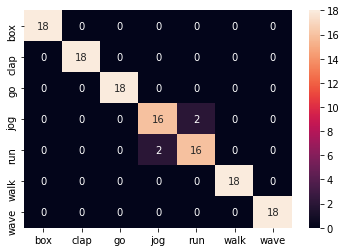

In [13]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'])

# 52% CSN no IG65m d=152

In [15]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/csn/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb.py')

In [16]:
from mmcv.runner import set_random_seed

cfg.model.backbone.pretrained = None
# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-no-transfer'

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


cfg.val_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=32,
        frame_interval=2,
        num_clips=1,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5)
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.test_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=10, test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]



cfg.train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=1),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
#     dict(type='RandomCrop', size=224),
    dict(type='RandomResizedCrop'),
    dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

# cfg.lr_config = dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-5),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

cfg.total_epochs = 100

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=8

cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=None,
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=False,
        zero_init_residual=False,
        in_channels=2),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'
img_norm_cfg = dict(mean=[128, 128], std=[128, 128])
train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-05-08 00:46:39,676 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /media/actrec/DATA/.virtualenvs/mmaction/mmaction2/childact-checkpoints/CSN-no-transfer
2021-05-08 00:46:39,677 - mmaction - INFO - workflow: [('train', 1)], max: 100 epochs
/media/actrec/DATA/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
2021-05-08 00:50:02,074 - mmaction - INFO - Epoch [1][100/132]	lr: 1.777e-05, eta: 7:21:47, time: 2.024, data_time: 0.035, memory: 21787, top1_acc: 0.1350, top5_acc: 0.7238, loss_cls: 2.0598, loss: 2.0598, grad_norm: 1519.5586
2021-05-08 00:54:23,554 - mmaction - INFO - Epoch [2][100/132]	lr: 2.480e-05, eta: 6:14:17, time: 1.994, data_time: 0.030, memory: 21787, top1_acc: 0.1350, top5_acc: 0.7362, loss_cls: 2.0437, loss: 2.0437, grad_norm: 1457.7541
2021-05-08 00:58:44,909 - mmaction - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.4 task/s, elapsed: 8s, ETA:     0s

2021-05-08 01:08:38,032 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 01:08:38,034 - mmaction - INFO - 
top1_acc	0.1746
top5_acc	0.7698
2021-05-08 01:08:38,034 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 01:08:38,035 - mmaction - INFO - 
mean_acc	0.1746
2021-05-08 01:08:40,145 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-05-08 01:08:40,146 - mmaction - INFO - Best top1_acc is 0.1746 at 5 epoch.
2021-05-08 01:08:40,147 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.1746, top5_acc: 0.7698, mean_class_accuracy: 0.1746
2021-05-08 01:11:59,663 - mmaction - INFO - Epoch [6][100/132]	lr: 5.293e-05, eta: 5:27:18, time: 1.995, data_time: 0.032, memory: 21787, top1_acc: 0.1338, top5_acc: 0.7312, loss_cls: 2.0174, loss: 2.0174, grad_norm: 1108.9898
2021-05-08 01:16:21,267 - mmaction - INFO - Epoch [7][100/132]	lr: 5.996e-05, eta: 5:21:49, time: 1.996, data_time: 0.032, memory: 21787, top1_acc: 0.1688, top5_acc: 0.735

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.9 task/s, elapsed: 7s, ETA:     0s

2021-05-08 01:30:35,511 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 01:30:35,514 - mmaction - INFO - 
top1_acc	0.2698
top5_acc	0.8571
2021-05-08 01:30:35,515 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 01:30:35,517 - mmaction - INFO - 
mean_acc	0.2698
2021-05-08 01:30:37,657 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-05-08 01:30:37,659 - mmaction - INFO - Best top1_acc is 0.2698 at 10 epoch.
2021-05-08 01:30:37,660 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.2698, top5_acc: 0.8571, mean_class_accuracy: 0.2698
2021-05-08 01:33:58,975 - mmaction - INFO - Epoch [11][100/132]	lr: 8.809e-05, eta: 5:04:04, time: 2.013, data_time: 0.030, memory: 21787, top1_acc: 0.1688, top5_acc: 0.7512, loss_cls: 1.9669, loss: 1.9669, grad_norm: 693.8755
2021-05-08 01:38:21,546 - mmaction - INFO - Epoch [12][100/132]	lr: 9.512e-05, eta: 5:00:08, time: 2.002, data_time: 0.032, memory: 21787, top1_acc: 0.1888, top5_acc: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 14.4 task/s, elapsed: 9s, ETA:     0s

2021-05-08 01:52:41,422 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 01:52:41,424 - mmaction - INFO - 
top1_acc	0.2302
top5_acc	0.8889
2021-05-08 01:52:41,425 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 01:52:41,427 - mmaction - INFO - 
mean_acc	0.2302
2021-05-08 01:52:41,428 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.2302, top5_acc: 0.8889, mean_class_accuracy: 0.2302
2021-05-08 01:56:02,246 - mmaction - INFO - Epoch [16][100/132]	lr: 1.232e-04, eta: 4:45:18, time: 2.008, data_time: 0.034, memory: 21787, top1_acc: 0.2125, top5_acc: 0.7725, loss_cls: 1.9536, loss: 1.9536, grad_norm: 514.9274
2021-05-08 02:00:23,841 - mmaction - INFO - Epoch [17][100/132]	lr: 1.250e-04, eta: 4:41:37, time: 1.995, data_time: 0.031, memory: 21787, top1_acc: 0.1762, top5_acc: 0.7925, loss_cls: 1.9641, loss: 1.9641, grad_norm: 477.2907
2021-05-08 02:04:45,703 - mmaction - INFO - Epoch [18][100/132]	lr: 1.250e-04, eta: 4:37:59, time: 1.999, data_time: 0.033, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.7 task/s, elapsed: 8s, ETA:     0s

2021-05-08 02:14:41,282 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 02:14:41,284 - mmaction - INFO - 
top1_acc	0.3730
top5_acc	0.8889
2021-05-08 02:14:41,285 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 02:14:41,286 - mmaction - INFO - 
mean_acc	0.3730
2021-05-08 02:14:43,512 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-05-08 02:14:43,513 - mmaction - INFO - Best top1_acc is 0.3730 at 20 epoch.
2021-05-08 02:14:43,514 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.3730, top5_acc: 0.8889, mean_class_accuracy: 0.3730
2021-05-08 02:18:03,550 - mmaction - INFO - Epoch [21][100/132]	lr: 1.250e-04, eta: 4:27:17, time: 2.000, data_time: 0.032, memory: 21787, top1_acc: 0.2050, top5_acc: 0.7887, loss_cls: 1.9331, loss: 1.9331, grad_norm: 371.6902
2021-05-08 02:22:25,252 - mmaction - INFO - Epoch [22][100/132]	lr: 1.250e-04, eta: 4:23:46, time: 1.998, data_time: 0.034, memory: 21787, top1_acc: 0.1850, top5_acc: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.4 task/s, elapsed: 8s, ETA:     0s

2021-05-08 02:36:41,018 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 02:36:41,020 - mmaction - INFO - 
top1_acc	0.3095
top5_acc	0.8730
2021-05-08 02:36:41,020 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 02:36:41,023 - mmaction - INFO - 
mean_acc	0.3095
2021-05-08 02:36:41,024 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.3095, top5_acc: 0.8730, mean_class_accuracy: 0.3095
2021-05-08 02:40:01,097 - mmaction - INFO - Epoch [26][100/132]	lr: 1.250e-04, eta: 4:09:49, time: 2.001, data_time: 0.032, memory: 21787, top1_acc: 0.2062, top5_acc: 0.8150, loss_cls: 1.9103, loss: 1.9103, grad_norm: 317.6817
2021-05-08 02:44:22,461 - mmaction - INFO - Epoch [27][100/132]	lr: 1.250e-04, eta: 4:06:20, time: 1.994, data_time: 0.031, memory: 21787, top1_acc: 0.2075, top5_acc: 0.8063, loss_cls: 1.9188, loss: 1.9188, grad_norm: 302.1534
2021-05-08 02:48:43,762 - mmaction - INFO - Epoch [28][100/132]	lr: 1.250e-04, eta: 4:02:52, time: 1.994, data_time: 0.032, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.4 task/s, elapsed: 8s, ETA:     0s

2021-05-08 02:58:37,119 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 02:58:37,120 - mmaction - INFO - 
top1_acc	0.4206
top5_acc	0.9206
2021-05-08 02:58:37,121 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 02:58:37,122 - mmaction - INFO - 
mean_acc	0.4206
2021-05-08 02:58:39,366 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-05-08 02:58:39,368 - mmaction - INFO - Best top1_acc is 0.4206 at 30 epoch.
2021-05-08 02:58:39,369 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.4206, top5_acc: 0.9206, mean_class_accuracy: 0.4206
2021-05-08 03:02:02,106 - mmaction - INFO - Epoch [31][100/132]	lr: 1.250e-04, eta: 3:52:40, time: 2.027, data_time: 0.032, memory: 21787, top1_acc: 0.2062, top5_acc: 0.8287, loss_cls: 1.9123, loss: 1.9123, grad_norm: 264.1676
2021-05-08 03:06:25,088 - mmaction - INFO - Epoch [32][100/132]	lr: 1.250e-04, eta: 3:49:14, time: 1.999, data_time: 0.035, memory: 21787, top1_acc: 0.2100, top5_acc: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.8 task/s, elapsed: 7s, ETA:     0s

2021-05-08 03:20:39,268 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 03:20:39,270 - mmaction - INFO - 
top1_acc	0.3810
top5_acc	0.9127
2021-05-08 03:20:39,271 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 03:20:39,273 - mmaction - INFO - 
mean_acc	0.3810
2021-05-08 03:20:39,273 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.3810, top5_acc: 0.9127, mean_class_accuracy: 0.3810
2021-05-08 03:23:58,931 - mmaction - INFO - Epoch [36][100/132]	lr: 1.250e-05, eta: 3:35:34, time: 1.996, data_time: 0.032, memory: 21787, top1_acc: 0.2250, top5_acc: 0.8287, loss_cls: 1.8712, loss: 1.8712, grad_norm: 260.7389
2021-05-08 03:28:20,284 - mmaction - INFO - Epoch [37][100/132]	lr: 1.250e-05, eta: 3:32:09, time: 1.994, data_time: 0.030, memory: 21787, top1_acc: 0.2362, top5_acc: 0.8263, loss_cls: 1.8687, loss: 1.8687, grad_norm: 259.4808
2021-05-08 03:32:44,133 - mmaction - INFO - Epoch [38][100/132]	lr: 1.250e-05, eta: 3:28:49, time: 2.019, data_time: 0.032, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 11.9 task/s, elapsed: 11s, ETA:     0s

2021-05-08 03:42:43,072 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 03:42:43,074 - mmaction - INFO - 
top1_acc	0.4048
top5_acc	0.9127
2021-05-08 03:42:43,075 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 03:42:43,076 - mmaction - INFO - 
mean_acc	0.4048
2021-05-08 03:42:43,077 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.4048, top5_acc: 0.9127, mean_class_accuracy: 0.4048
2021-05-08 03:46:09,486 - mmaction - INFO - Epoch [41][100/132]	lr: 1.250e-05, eta: 3:18:48, time: 2.064, data_time: 0.030, memory: 21787, top1_acc: 0.2375, top5_acc: 0.8425, loss_cls: 1.8530, loss: 1.8530, grad_norm: 258.8275
2021-05-08 03:50:35,223 - mmaction - INFO - Epoch [42][100/132]	lr: 1.250e-05, eta: 3:15:29, time: 2.026, data_time: 0.039, memory: 21787, top1_acc: 0.2412, top5_acc: 0.8413, loss_cls: 1.8657, loss: 1.8657, grad_norm: 257.7501
2021-05-08 03:54:56,790 - mmaction - INFO - Epoch [43][100/132]	lr: 1.250e-05, eta: 3:12:05, time: 1.996, data_time: 0.032, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.3 task/s, elapsed: 8s, ETA:     0s

2021-05-08 04:04:50,346 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 04:04:50,348 - mmaction - INFO - 
top1_acc	0.4603
top5_acc	0.9048
2021-05-08 04:04:50,349 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 04:04:50,350 - mmaction - INFO - 
mean_acc	0.4603
2021-05-08 04:04:52,457 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2021-05-08 04:04:52,458 - mmaction - INFO - Best top1_acc is 0.4603 at 45 epoch.
2021-05-08 04:04:52,459 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.4603, top5_acc: 0.9048, mean_class_accuracy: 0.4603
2021-05-08 04:08:27,838 - mmaction - INFO - Epoch [46][100/132]	lr: 1.250e-05, eta: 3:02:14, time: 2.154, data_time: 0.030, memory: 21787, top1_acc: 0.2325, top5_acc: 0.8287, loss_cls: 1.8454, loss: 1.8454, grad_norm: 259.2450
2021-05-08 04:12:50,768 - mmaction - INFO - Epoch [47][100/132]	lr: 1.250e-05, eta: 2:58:51, time: 2.004, data_time: 0.041, memory: 21787, top1_acc: 0.2475, top5_acc: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.1 task/s, elapsed: 8s, ETA:     0s

2021-05-08 04:27:06,606 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 04:27:06,608 - mmaction - INFO - 
top1_acc	0.4524
top5_acc	0.9127
2021-05-08 04:27:06,608 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 04:27:06,610 - mmaction - INFO - 
mean_acc	0.4524
2021-05-08 04:27:06,611 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.4524, top5_acc: 0.9127, mean_class_accuracy: 0.4524
2021-05-08 04:30:26,490 - mmaction - INFO - Epoch [51][100/132]	lr: 1.250e-06, eta: 2:45:18, time: 1.999, data_time: 0.035, memory: 21787, top1_acc: 0.2162, top5_acc: 0.8237, loss_cls: 1.8923, loss: 1.8923, grad_norm: 253.9602
2021-05-08 04:34:48,358 - mmaction - INFO - Epoch [52][100/132]	lr: 1.250e-06, eta: 2:41:55, time: 1.999, data_time: 0.035, memory: 21787, top1_acc: 0.2512, top5_acc: 0.8213, loss_cls: 1.8692, loss: 1.8692, grad_norm: 254.2343
2021-05-08 04:39:10,763 - mmaction - INFO - Epoch [53][100/132]	lr: 1.250e-06, eta: 2:38:33, time: 2.004, data_time: 0.034, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 12.8 task/s, elapsed: 10s, ETA:     0s

2021-05-08 04:49:08,312 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 04:49:08,314 - mmaction - INFO - 
top1_acc	0.4286
top5_acc	0.9127
2021-05-08 04:49:08,315 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 04:49:08,316 - mmaction - INFO - 
mean_acc	0.4286
2021-05-08 04:49:08,317 - mmaction - INFO - Epoch(val) [55][132]	top1_acc: 0.4286, top5_acc: 0.9127, mean_class_accuracy: 0.4286
2021-05-08 04:52:29,039 - mmaction - INFO - Epoch [56][100/132]	lr: 1.250e-06, eta: 2:28:26, time: 2.007, data_time: 0.035, memory: 21787, top1_acc: 0.2213, top5_acc: 0.8213, loss_cls: 1.8746, loss: 1.8746, grad_norm: 253.0581
2021-05-08 04:56:52,004 - mmaction - INFO - Epoch [57][100/132]	lr: 1.250e-06, eta: 2:25:04, time: 2.001, data_time: 0.031, memory: 21787, top1_acc: 0.2400, top5_acc: 0.7963, loss_cls: 1.8938, loss: 1.8938, grad_norm: 262.8867
2021-05-08 05:01:14,701 - mmaction - INFO - Epoch [58][100/132]	lr: 1.250e-06, eta: 2:21:42, time: 2.007, data_time: 0.037, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 13.4 task/s, elapsed: 9s, ETA:     0s

2021-05-08 05:11:14,999 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 05:11:15,001 - mmaction - INFO - 
top1_acc	0.4206
top5_acc	0.8968
2021-05-08 05:11:15,002 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 05:11:15,004 - mmaction - INFO - 
mean_acc	0.4206
2021-05-08 05:11:15,005 - mmaction - INFO - Epoch(val) [60][132]	top1_acc: 0.4206, top5_acc: 0.8968, mean_class_accuracy: 0.4206
2021-05-08 05:14:35,400 - mmaction - INFO - Epoch [61][100/132]	lr: 1.250e-06, eta: 2:11:37, time: 2.004, data_time: 0.042, memory: 21787, top1_acc: 0.2437, top5_acc: 0.8237, loss_cls: 1.8706, loss: 1.8706, grad_norm: 250.4366
2021-05-08 05:18:57,336 - mmaction - INFO - Epoch [62][100/132]	lr: 1.250e-06, eta: 2:08:15, time: 2.000, data_time: 0.035, memory: 21787, top1_acc: 0.2425, top5_acc: 0.8275, loss_cls: 1.8782, loss: 1.8782, grad_norm: 254.9917
2021-05-08 05:23:19,426 - mmaction - INFO - Epoch [63][100/132]	lr: 1.250e-06, eta: 2:04:53, time: 2.002, data_time: 0.034, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.0 task/s, elapsed: 8s, ETA:     0s

2021-05-08 05:33:12,036 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 05:33:12,039 - mmaction - INFO - 
top1_acc	0.4048
top5_acc	0.9048
2021-05-08 05:33:12,040 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 05:33:12,041 - mmaction - INFO - 
mean_acc	0.4048
2021-05-08 05:33:12,043 - mmaction - INFO - Epoch(val) [65][132]	top1_acc: 0.4048, top5_acc: 0.9048, mean_class_accuracy: 0.4048
2021-05-08 05:36:31,560 - mmaction - INFO - Epoch [66][100/132]	lr: 1.250e-06, eta: 1:54:47, time: 1.995, data_time: 0.033, memory: 21787, top1_acc: 0.2250, top5_acc: 0.8413, loss_cls: 1.8667, loss: 1.8667, grad_norm: 257.5629
2021-05-08 05:40:53,544 - mmaction - INFO - Epoch [67][100/132]	lr: 1.250e-06, eta: 1:51:25, time: 2.000, data_time: 0.034, memory: 21787, top1_acc: 0.2425, top5_acc: 0.8337, loss_cls: 1.8624, loss: 1.8624, grad_norm: 255.7543
2021-05-08 05:45:15,371 - mmaction - INFO - Epoch [68][100/132]	lr: 1.250e-06, eta: 1:48:04, time: 1.999, data_time: 0.033, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.6 task/s, elapsed: 8s, ETA:     0s

2021-05-08 05:55:08,471 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 05:55:08,472 - mmaction - INFO - 
top1_acc	0.4683
top5_acc	0.9048
2021-05-08 05:55:08,472 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 05:55:08,473 - mmaction - INFO - 
mean_acc	0.4683
2021-05-08 05:55:10,525 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_70.pth.
2021-05-08 05:55:10,526 - mmaction - INFO - Best top1_acc is 0.4683 at 70 epoch.
2021-05-08 05:55:10,527 - mmaction - INFO - Epoch(val) [70][132]	top1_acc: 0.4683, top5_acc: 0.9048, mean_class_accuracy: 0.4683
2021-05-08 05:58:37,916 - mmaction - INFO - Epoch [71][100/132]	lr: 1.250e-06, eta: 1:38:02, time: 2.074, data_time: 0.038, memory: 21787, top1_acc: 0.2512, top5_acc: 0.8200, loss_cls: 1.8634, loss: 1.8634, grad_norm: 251.7808
2021-05-08 06:03:02,664 - mmaction - INFO - Epoch [72][100/132]	lr: 1.250e-06, eta: 1:34:41, time: 2.028, data_time: 0.044, memory: 21787, top1_acc: 0.2387, top5_acc: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.1 task/s, elapsed: 8s, ETA:     0s

2021-05-08 06:17:19,948 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 06:17:19,949 - mmaction - INFO - 
top1_acc	0.4365
top5_acc	0.8968
2021-05-08 06:17:19,950 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 06:17:19,951 - mmaction - INFO - 
mean_acc	0.4365
2021-05-08 06:17:19,951 - mmaction - INFO - Epoch(val) [75][132]	top1_acc: 0.4365, top5_acc: 0.8968, mean_class_accuracy: 0.4365
2021-05-08 06:20:39,622 - mmaction - INFO - Epoch [76][100/132]	lr: 1.250e-06, eta: 1:21:15, time: 1.997, data_time: 0.033, memory: 21787, top1_acc: 0.2362, top5_acc: 0.8400, loss_cls: 1.8638, loss: 1.8638, grad_norm: 258.5788
2021-05-08 06:25:01,351 - mmaction - INFO - Epoch [77][100/132]	lr: 1.250e-06, eta: 1:17:54, time: 1.998, data_time: 0.033, memory: 21787, top1_acc: 0.2475, top5_acc: 0.8387, loss_cls: 1.8642, loss: 1.8642, grad_norm: 255.0980
2021-05-08 06:29:22,938 - mmaction - INFO - Epoch [78][100/132]	lr: 1.250e-06, eta: 1:14:32, time: 1.997, data_time: 0.035, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 11.8 task/s, elapsed: 11s, ETA:     0s

2021-05-08 06:39:20,504 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 06:39:20,506 - mmaction - INFO - 
top1_acc	0.4286
top5_acc	0.8968
2021-05-08 06:39:20,507 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 06:39:20,509 - mmaction - INFO - 
mean_acc	0.4286
2021-05-08 06:39:20,510 - mmaction - INFO - Epoch(val) [80][132]	top1_acc: 0.4286, top5_acc: 0.8968, mean_class_accuracy: 0.4286
2021-05-08 06:42:40,156 - mmaction - INFO - Epoch [81][100/132]	lr: 1.250e-06, eta: 1:04:28, time: 1.996, data_time: 0.032, memory: 21787, top1_acc: 0.1963, top5_acc: 0.8087, loss_cls: 1.9209, loss: 1.9209, grad_norm: 259.2693
2021-05-08 06:47:02,362 - mmaction - INFO - Epoch [82][100/132]	lr: 1.250e-06, eta: 1:01:07, time: 2.003, data_time: 0.035, memory: 21787, top1_acc: 0.2400, top5_acc: 0.8375, loss_cls: 1.8596, loss: 1.8596, grad_norm: 252.6249
2021-05-08 06:51:24,357 - mmaction - INFO - Epoch [83][100/132]	lr: 1.250e-06, eta: 0:57:45, time: 2.001, data_time: 0.034, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.2 task/s, elapsed: 8s, ETA:     0s

2021-05-08 07:01:17,698 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 07:01:17,699 - mmaction - INFO - 
top1_acc	0.4365
top5_acc	0.9127
2021-05-08 07:01:17,699 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 07:01:17,700 - mmaction - INFO - 
mean_acc	0.4365
2021-05-08 07:01:17,701 - mmaction - INFO - Epoch(val) [85][132]	top1_acc: 0.4365, top5_acc: 0.9127, mean_class_accuracy: 0.4365
2021-05-08 07:04:37,382 - mmaction - INFO - Epoch [86][100/132]	lr: 1.250e-06, eta: 0:47:42, time: 1.997, data_time: 0.034, memory: 21787, top1_acc: 0.2175, top5_acc: 0.8375, loss_cls: 1.8636, loss: 1.8636, grad_norm: 254.3374
2021-05-08 07:08:59,175 - mmaction - INFO - Epoch [87][100/132]	lr: 1.250e-06, eta: 0:44:21, time: 1.998, data_time: 0.031, memory: 21787, top1_acc: 0.2437, top5_acc: 0.8475, loss_cls: 1.8298, loss: 1.8298, grad_norm: 256.1563
2021-05-08 07:13:20,917 - mmaction - INFO - Epoch [88][100/132]	lr: 1.250e-06, eta: 0:41:00, time: 1.998, data_time: 0.034, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.7 task/s, elapsed: 8s, ETA:     0s

2021-05-08 07:23:14,633 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 07:23:14,635 - mmaction - INFO - 
top1_acc	0.5079
top5_acc	0.9048
2021-05-08 07:23:14,635 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 07:23:14,637 - mmaction - INFO - 
mean_acc	0.5079
2021-05-08 07:23:16,917 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2021-05-08 07:23:16,918 - mmaction - INFO - Best top1_acc is 0.5079 at 90 epoch.
2021-05-08 07:23:16,919 - mmaction - INFO - Epoch(val) [90][132]	top1_acc: 0.5079, top5_acc: 0.9048, mean_class_accuracy: 0.5079
2021-05-08 07:26:38,586 - mmaction - INFO - Epoch [91][100/132]	lr: 1.250e-06, eta: 0:30:57, time: 2.017, data_time: 0.032, memory: 21787, top1_acc: 0.2213, top5_acc: 0.8063, loss_cls: 1.9045, loss: 1.9045, grad_norm: 258.6824
2021-05-08 07:31:01,528 - mmaction - INFO - Epoch [92][100/132]	lr: 1.250e-06, eta: 0:27:36, time: 1.995, data_time: 0.031, memory: 21787, top1_acc: 0.2300, top5_acc: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 15.8 task/s, elapsed: 8s, ETA:     0s

2021-05-08 07:45:15,924 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 07:45:15,926 - mmaction - INFO - 
top1_acc	0.4444
top5_acc	0.8889
2021-05-08 07:45:15,927 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 07:45:15,929 - mmaction - INFO - 
mean_acc	0.4444
2021-05-08 07:45:15,930 - mmaction - INFO - Epoch(val) [95][132]	top1_acc: 0.4444, top5_acc: 0.8889, mean_class_accuracy: 0.4444
2021-05-08 07:48:35,510 - mmaction - INFO - Epoch [96][100/132]	lr: 1.250e-06, eta: 0:14:12, time: 1.996, data_time: 0.031, memory: 21787, top1_acc: 0.2525, top5_acc: 0.8287, loss_cls: 1.8477, loss: 1.8477, grad_norm: 254.0920
2021-05-08 07:52:56,971 - mmaction - INFO - Epoch [97][100/132]	lr: 1.250e-06, eta: 0:10:51, time: 1.995, data_time: 0.030, memory: 21787, top1_acc: 0.2412, top5_acc: 0.8325, loss_cls: 1.8744, loss: 1.8744, grad_norm: 256.2244
2021-05-08 07:57:18,408 - mmaction - INFO - Epoch [98][100/132]	lr: 1.250e-06, eta: 0:07:30, time: 1.994, data_time: 0.030, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.3 task/s, elapsed: 8s, ETA:     0s

2021-05-08 08:07:13,134 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 08:07:13,136 - mmaction - INFO - 
top1_acc	0.4762
top5_acc	0.9127
2021-05-08 08:07:13,137 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 08:07:13,140 - mmaction - INFO - 
mean_acc	0.4762
2021-05-08 08:07:13,141 - mmaction - INFO - Epoch(val) [100][132]	top1_acc: 0.4762, top5_acc: 0.9127, mean_class_accuracy: 0.4762


In [7]:
import pickle

with open(f"{cfg.work_dir}/model100e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model
import pickle
import mmcv
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model100e", 'rb'))

In [18]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.5 task/s, elapsed: 278s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5238
top5_acc	0.9683

Evaluating mean_class_accuracy ...

mean_acc	0.5238
top1_acc: 0.5238
top5_acc: 0.9683
mean_class_accuracy: 0.5238


<AxesSubplot:>

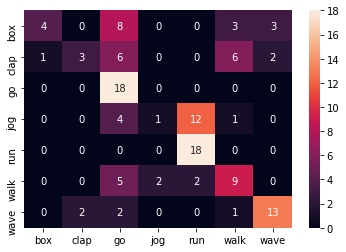

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'])

# CSN no IG65m, d=50

In [29]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/csn/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb.py')

In [30]:
from mmcv.runner import set_random_seed

cfg.model.backbone.pretrained = None
cfg.model.backbone.depth = 50
# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-no-transfer-d50'

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


cfg.val_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=32,
        frame_interval=2,
        num_clips=1,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5)
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.test_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=10, test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]



cfg.train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=1),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
#     dict(type='RandomCrop', size=224),
    dict(type='RandomResizedCrop'),
    dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

# cfg.lr_config = dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-5),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

cfg.total_epochs = 200

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=8

cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=None,
        depth=50,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=False,
        zero_init_residual=False,
        in_channels=2),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'
img_norm_cfg = dict(mean=[128, 128], std=[128, 128])
train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_

In [31]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-05-08 16:16:31,725 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /media/actrec/DATA/.virtualenvs/mmaction/mmaction2/childact-checkpoints/CSN-no-transfer-d50
2021-05-08 16:16:31,726 - mmaction - INFO - workflow: [('train', 1)], max: 200 epochs
2021-05-08 16:18:33,306 - mmaction - INFO - Epoch [1][100/132]	lr: 1.777e-05, eta: 8:52:53, time: 1.216, data_time: 0.034, memory: 21787, top1_acc: 0.1325, top5_acc: 0.7075, loss_cls: 2.0615, loss: 2.0615, grad_norm: 111.4532
2021-05-08 16:21:17,410 - mmaction - INFO - Epoch [2][100/132]	lr: 2.480e-05, eta: 7:43:11, time: 1.248, data_time: 0.034, memory: 21787, top1_acc: 0.1575, top5_acc: 0.7462, loss_cls: 1.9853, loss: 1.9853, grad_norm: 101.7177
2021-05-08 16:23:56,132 - mmaction - INFO - Epoch [3][100/132]	lr: 3.184e-05, eta: 7:17:34, time: 1.207, data_time: 0.032, memory: 21787, top1_acc: 0.1588, top5_acc: 0.7750, loss_cls: 1.9705, loss: 1.9705, grad_norm: 96.8677
2021-05-08 16:26:30,605 - mmaction

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.1 task/s, elapsed: 5s, ETA:     0s

2021-05-08 16:29:52,449 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 16:29:52,451 - mmaction - INFO - 
top1_acc	0.2302
top5_acc	0.9286
2021-05-08 16:29:52,452 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 16:29:52,453 - mmaction - INFO - 
mean_acc	0.2302
2021-05-08 16:29:53,372 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-05-08 16:29:53,373 - mmaction - INFO - Best top1_acc is 0.2302 at 5 epoch.
2021-05-08 16:29:53,374 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.2302, top5_acc: 0.9286, mean_class_accuracy: 0.2302
2021-05-08 16:31:52,618 - mmaction - INFO - Epoch [6][100/132]	lr: 5.293e-05, eta: 6:45:50, time: 1.192, data_time: 0.032, memory: 21787, top1_acc: 0.1975, top5_acc: 0.7850, loss_cls: 1.9298, loss: 1.9298, grad_norm: 73.6212
2021-05-08 16:34:30,113 - mmaction - INFO - Epoch [7][100/132]	lr: 5.996e-05, eta: 6:40:37, time: 1.188, data_time: 0.030, memory: 21787, top1_acc: 0.2000, top5_acc: 0.7987,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 20.7 task/s, elapsed: 6s, ETA:     0s

2021-05-08 16:43:34,388 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 16:43:34,390 - mmaction - INFO - 
top1_acc	0.3730
top5_acc	0.9524
2021-05-08 16:43:34,390 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 16:43:34,392 - mmaction - INFO - 
mean_acc	0.3730
2021-05-08 16:43:35,351 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-05-08 16:43:35,352 - mmaction - INFO - Best top1_acc is 0.3730 at 10 epoch.
2021-05-08 16:43:35,353 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.3730, top5_acc: 0.9524, mean_class_accuracy: 0.3730
2021-05-08 16:45:40,032 - mmaction - INFO - Epoch [11][100/132]	lr: 8.809e-05, eta: 6:33:11, time: 1.247, data_time: 0.033, memory: 21787, top1_acc: 0.2450, top5_acc: 0.8438, loss_cls: 1.8661, loss: 1.8661, grad_norm: 52.8768
2021-05-08 16:48:30,857 - mmaction - INFO - Epoch [12][100/132]	lr: 9.512e-05, eta: 6:33:21, time: 1.331, data_time: 0.035, memory: 21787, top1_acc: 0.2412, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.6 task/s, elapsed: 7s, ETA:     0s

2021-05-08 16:57:26,609 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 16:57:26,611 - mmaction - INFO - 
top1_acc	0.5476
top5_acc	0.9921
2021-05-08 16:57:26,612 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 16:57:26,613 - mmaction - INFO - 
mean_acc	0.5476
2021-05-08 16:57:27,553 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-05-08 16:57:27,554 - mmaction - INFO - Best top1_acc is 0.5476 at 15 epoch.
2021-05-08 16:57:27,555 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.5476, top5_acc: 0.9921, mean_class_accuracy: 0.5476
2021-05-08 16:59:26,210 - mmaction - INFO - Epoch [16][100/132]	lr: 1.232e-04, eta: 6:23:09, time: 1.186, data_time: 0.037, memory: 21787, top1_acc: 0.3475, top5_acc: 0.9000, loss_cls: 1.6368, loss: 1.6368, grad_norm: 37.8274
2021-05-08 17:02:10,845 - mmaction - INFO - Epoch [17][100/132]	lr: 1.250e-04, eta: 6:20:49, time: 1.234, data_time: 0.030, memory: 21787, top1_acc: 0.3475, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 22.0 task/s, elapsed: 6s, ETA:     0s

2021-05-08 17:10:44,458 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 17:10:44,459 - mmaction - INFO - 
top1_acc	0.7540
top5_acc	1.0000
2021-05-08 17:10:44,460 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 17:10:44,461 - mmaction - INFO - 
mean_acc	0.7540
2021-05-08 17:10:45,360 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-05-08 17:10:45,361 - mmaction - INFO - Best top1_acc is 0.7540 at 20 epoch.
2021-05-08 17:10:45,362 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.7540, top5_acc: 1.0000, mean_class_accuracy: 0.7540
2021-05-08 17:12:43,132 - mmaction - INFO - Epoch [21][100/132]	lr: 1.250e-04, eta: 6:08:53, time: 1.178, data_time: 0.034, memory: 21787, top1_acc: 0.4788, top5_acc: 0.9487, loss_cls: 1.3162, loss: 1.3162, grad_norm: 33.5218
2021-05-08 17:15:17,064 - mmaction - INFO - Epoch [22][100/132]	lr: 1.250e-04, eta: 6:05:53, time: 1.165, data_time: 0.031, memory: 21787, top1_acc: 0.4813, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.1 task/s, elapsed: 5s, ETA:     0s

2021-05-08 17:23:38,908 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 17:23:38,911 - mmaction - INFO - 
top1_acc	0.7222
top5_acc	1.0000
2021-05-08 17:23:38,911 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 17:23:38,913 - mmaction - INFO - 
mean_acc	0.7222
2021-05-08 17:23:38,914 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.7222, top5_acc: 1.0000, mean_class_accuracy: 0.7222
2021-05-08 17:25:34,802 - mmaction - INFO - Epoch [26][100/132]	lr: 1.250e-04, eta: 5:54:14, time: 1.159, data_time: 0.031, memory: 21787, top1_acc: 0.5262, top5_acc: 0.9575, loss_cls: 1.1960, loss: 1.1960, grad_norm: 32.2553
2021-05-08 17:28:11,365 - mmaction - INFO - Epoch [27][100/132]	lr: 1.250e-04, eta: 5:51:55, time: 1.193, data_time: 0.032, memory: 21787, top1_acc: 0.5150, top5_acc: 0.9563, loss_cls: 1.2023, loss: 1.2023, grad_norm: 32.3263
2021-05-08 17:30:47,753 - mmaction - INFO - Epoch [28][100/132]	lr: 1.250e-04, eta: 5:49:27, time: 1.177, data_time: 0.032, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 22.9 task/s, elapsed: 6s, ETA:     0s

2021-05-08 17:36:40,181 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 17:36:40,183 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-05-08 17:36:40,184 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 17:36:40,187 - mmaction - INFO - 
mean_acc	0.8016
2021-05-08 17:36:41,117 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-05-08 17:36:41,118 - mmaction - INFO - Best top1_acc is 0.8016 at 30 epoch.
2021-05-08 17:36:41,119 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-05-08 17:38:42,482 - mmaction - INFO - Epoch [31][100/132]	lr: 1.250e-04, eta: 5:42:35, time: 1.214, data_time: 0.035, memory: 21787, top1_acc: 0.5550, top5_acc: 0.9487, loss_cls: 1.1291, loss: 1.1291, grad_norm: 30.4286
2021-05-08 17:41:17,980 - mmaction - INFO - Epoch [32][100/132]	lr: 1.250e-04, eta: 5:40:17, time: 1.182, data_time: 0.031, memory: 21787, top1_acc: 0.5813, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.8 task/s, elapsed: 6s, ETA:     0s

2021-05-08 17:49:53,408 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 17:49:53,410 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-05-08 17:49:53,410 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 17:49:53,411 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 17:49:54,325 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2021-05-08 17:49:54,326 - mmaction - INFO - Best top1_acc is 0.8333 at 35 epoch.
2021-05-08 17:49:54,327 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333
2021-05-08 17:51:54,024 - mmaction - INFO - Epoch [36][100/132]	lr: 1.250e-05, eta: 5:31:47, time: 1.197, data_time: 0.035, memory: 21787, top1_acc: 0.5988, top5_acc: 0.9725, loss_cls: 1.0413, loss: 1.0413, grad_norm: 29.2241
2021-05-08 17:54:32,435 - mmaction - INFO - Epoch [37][100/132]	lr: 1.250e-05, eta: 5:29:39, time: 1.197, data_time: 0.031, memory: 21787, top1_acc: 0.6188, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.2 task/s, elapsed: 7s, ETA:     0s

2021-05-08 18:03:21,757 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 18:03:21,759 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-05-08 18:03:21,759 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 18:03:21,761 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 18:03:21,762 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333
2021-05-08 18:05:19,079 - mmaction - INFO - Epoch [41][100/132]	lr: 1.250e-05, eta: 5:21:16, time: 1.173, data_time: 0.031, memory: 21787, top1_acc: 0.6188, top5_acc: 0.9537, loss_cls: 0.9839, loss: 0.9839, grad_norm: 27.4950
2021-05-08 18:07:55,021 - mmaction - INFO - Epoch [42][100/132]	lr: 1.250e-05, eta: 5:19:09, time: 1.196, data_time: 0.030, memory: 21787, top1_acc: 0.6162, top5_acc: 0.9600, loss_cls: 1.0026, loss: 1.0026, grad_norm: 29.4950
2021-05-08 18:10:30,346 - mmaction - INFO - Epoch [43][100/132]	lr: 1.250e-05, eta: 5:16:58, time: 1.182, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.9 task/s, elapsed: 5s, ETA:     0s

2021-05-08 18:16:20,930 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 18:16:20,931 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-05-08 18:16:20,932 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 18:16:20,933 - mmaction - INFO - 
mean_acc	0.8095
2021-05-08 18:16:20,934 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-05-08 18:18:17,628 - mmaction - INFO - Epoch [46][100/132]	lr: 1.250e-05, eta: 5:10:04, time: 1.167, data_time: 0.030, memory: 21787, top1_acc: 0.6150, top5_acc: 0.9563, loss_cls: 0.9979, loss: 0.9979, grad_norm: 28.9985
2021-05-08 18:20:54,065 - mmaction - INFO - Epoch [47][100/132]	lr: 1.250e-05, eta: 5:07:55, time: 1.183, data_time: 0.032, memory: 21787, top1_acc: 0.6012, top5_acc: 0.9663, loss_cls: 0.9797, loss: 0.9797, grad_norm: 27.6947
2021-05-08 18:23:30,473 - mmaction - INFO - Epoch [48][100/132]	lr: 1.250e-05, eta: 5:05:48, time: 1.185, data_time: 0.032, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.2 task/s, elapsed: 5s, ETA:     0s

2021-05-08 18:29:22,444 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 18:29:22,446 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-08 18:29:22,447 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 18:29:22,449 - mmaction - INFO - 
mean_acc	0.8413
2021-05-08 18:29:23,381 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_50.pth.
2021-05-08 18:29:23,382 - mmaction - INFO - Best top1_acc is 0.8413 at 50 epoch.
2021-05-08 18:29:23,383 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-08 18:31:18,948 - mmaction - INFO - Epoch [51][100/132]	lr: 1.250e-06, eta: 4:59:06, time: 1.156, data_time: 0.031, memory: 21787, top1_acc: 0.6288, top5_acc: 0.9637, loss_cls: 0.9773, loss: 0.9773, grad_norm: 27.8705
2021-05-08 18:33:52,741 - mmaction - INFO - Epoch [52][100/132]	lr: 1.250e-06, eta: 4:56:54, time: 1.161, data_time: 0.031, memory: 21787, top1_acc: 0.6525, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 23.8 task/s, elapsed: 5s, ETA:     0s

2021-05-08 18:42:17,520 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 18:42:17,522 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-05-08 18:42:17,524 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 18:42:17,526 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 18:42:17,527 - mmaction - INFO - Epoch(val) [55][132]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333
2021-05-08 18:44:13,618 - mmaction - INFO - Epoch [56][100/132]	lr: 1.250e-06, eta: 4:48:19, time: 1.161, data_time: 0.030, memory: 21787, top1_acc: 0.6350, top5_acc: 0.9650, loss_cls: 0.9434, loss: 0.9434, grad_norm: 27.6465
2021-05-08 18:46:46,406 - mmaction - INFO - Epoch [57][100/132]	lr: 1.250e-06, eta: 4:46:09, time: 1.159, data_time: 0.032, memory: 21787, top1_acc: 0.6125, top5_acc: 0.9712, loss_cls: 0.9688, loss: 0.9688, grad_norm: 27.6768
2021-05-08 18:49:18,519 - mmaction - INFO - Epoch [58][100/132]	lr: 1.250e-06, eta: 4:43:58, time: 1.154, data_time: 0.032, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.5 task/s, elapsed: 5s, ETA:     0s

2021-05-08 18:55:03,907 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 18:55:03,910 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-08 18:55:03,911 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 18:55:03,912 - mmaction - INFO - 
mean_acc	0.8413
2021-05-08 18:55:03,913 - mmaction - INFO - Epoch(val) [60][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-08 18:57:00,082 - mmaction - INFO - Epoch [61][100/132]	lr: 1.250e-06, eta: 4:37:31, time: 1.162, data_time: 0.031, memory: 21787, top1_acc: 0.5962, top5_acc: 0.9663, loss_cls: 0.9811, loss: 0.9811, grad_norm: 28.4621
2021-05-08 18:59:34,587 - mmaction - INFO - Epoch [62][100/132]	lr: 1.250e-06, eta: 4:35:23, time: 1.159, data_time: 0.030, memory: 21787, top1_acc: 0.6362, top5_acc: 0.9738, loss_cls: 0.9274, loss: 0.9274, grad_norm: 27.6005
2021-05-08 19:02:07,354 - mmaction - INFO - Epoch [63][100/132]	lr: 1.250e-06, eta: 4:33:18, time: 1.170, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 20.2 task/s, elapsed: 6s, ETA:     0s

2021-05-08 19:07:57,526 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 19:07:57,528 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-05-08 19:07:57,528 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 19:07:57,530 - mmaction - INFO - 
mean_acc	0.8254
2021-05-08 19:07:57,530 - mmaction - INFO - Epoch(val) [65][132]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-05-08 19:09:59,616 - mmaction - INFO - Epoch [66][100/132]	lr: 1.250e-06, eta: 4:27:15, time: 1.221, data_time: 0.030, memory: 21787, top1_acc: 0.6325, top5_acc: 0.9613, loss_cls: 0.9464, loss: 0.9464, grad_norm: 27.4475
2021-05-08 19:12:35,161 - mmaction - INFO - Epoch [67][100/132]	lr: 1.250e-06, eta: 4:25:12, time: 1.176, data_time: 0.031, memory: 21787, top1_acc: 0.6025, top5_acc: 0.9500, loss_cls: 1.0144, loss: 1.0144, grad_norm: 28.2501
2021-05-08 19:15:10,267 - mmaction - INFO - Epoch [68][100/132]	lr: 1.250e-06, eta: 4:23:11, time: 1.185, data_time: 0.038, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.0 task/s, elapsed: 5s, ETA:     0s

2021-05-08 19:21:00,652 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 19:21:00,654 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	0.9921
2021-05-08 19:21:00,655 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 19:21:00,657 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 19:21:00,658 - mmaction - INFO - Epoch(val) [70][132]	top1_acc: 0.8333, top5_acc: 0.9921, mean_class_accuracy: 0.8333
2021-05-08 19:22:56,418 - mmaction - INFO - Epoch [71][100/132]	lr: 1.250e-06, eta: 4:16:54, time: 1.158, data_time: 0.033, memory: 21787, top1_acc: 0.6062, top5_acc: 0.9500, loss_cls: 1.0040, loss: 1.0040, grad_norm: 28.1197
2021-05-08 19:25:31,002 - mmaction - INFO - Epoch [72][100/132]	lr: 1.250e-06, eta: 4:14:47, time: 1.150, data_time: 0.030, memory: 21787, top1_acc: 0.6500, top5_acc: 0.9725, loss_cls: 0.9113, loss: 0.9113, grad_norm: 26.7875
2021-05-08 19:28:07,089 - mmaction - INFO - Epoch [73][100/132]	lr: 1.250e-06, eta: 4:12:46, time: 1.181, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.4 task/s, elapsed: 5s, ETA:     0s

2021-05-08 19:34:02,296 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 19:34:02,298 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-05-08 19:34:02,299 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 19:34:02,302 - mmaction - INFO - 
mean_acc	0.8175
2021-05-08 19:34:02,303 - mmaction - INFO - Epoch(val) [75][132]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-05-08 19:36:02,646 - mmaction - INFO - Epoch [76][100/132]	lr: 1.250e-06, eta: 4:06:54, time: 1.203, data_time: 0.032, memory: 21787, top1_acc: 0.6238, top5_acc: 0.9675, loss_cls: 0.9595, loss: 0.9595, grad_norm: 27.7671
2021-05-08 19:38:35,262 - mmaction - INFO - Epoch [77][100/132]	lr: 1.250e-06, eta: 4:04:50, time: 1.163, data_time: 0.030, memory: 21787, top1_acc: 0.6188, top5_acc: 0.9663, loss_cls: 0.9801, loss: 0.9801, grad_norm: 27.9649
2021-05-08 19:41:12,192 - mmaction - INFO - Epoch [78][100/132]	lr: 1.250e-06, eta: 4:02:49, time: 1.182, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.8 task/s, elapsed: 5s, ETA:     0s

2021-05-08 19:47:03,228 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 19:47:03,230 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-05-08 19:47:03,231 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 19:47:03,233 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 19:47:03,234 - mmaction - INFO - Epoch(val) [80][132]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333
2021-05-08 19:48:58,994 - mmaction - INFO - Epoch [81][100/132]	lr: 1.250e-06, eta: 3:56:38, time: 1.158, data_time: 0.030, memory: 21787, top1_acc: 0.6600, top5_acc: 0.9750, loss_cls: 0.8792, loss: 0.8792, grad_norm: 25.9226
2021-05-08 19:51:31,761 - mmaction - INFO - Epoch [82][100/132]	lr: 1.250e-06, eta: 3:54:34, time: 1.153, data_time: 0.031, memory: 21787, top1_acc: 0.6175, top5_acc: 0.9625, loss_cls: 0.9918, loss: 0.9918, grad_norm: 28.7035
2021-05-08 19:54:06,058 - mmaction - INFO - Epoch [83][100/132]	lr: 1.250e-06, eta: 3:52:34, time: 1.187, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.2 task/s, elapsed: 5s, ETA:     0s

2021-05-08 19:59:51,402 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 19:59:51,403 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	0.9921
2021-05-08 19:59:51,404 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 19:59:51,405 - mmaction - INFO - 
mean_acc	0.8095
2021-05-08 19:59:51,406 - mmaction - INFO - Epoch(val) [85][132]	top1_acc: 0.8095, top5_acc: 0.9921, mean_class_accuracy: 0.8095
2021-05-08 20:01:49,455 - mmaction - INFO - Epoch [86][100/132]	lr: 1.250e-06, eta: 3:46:26, time: 1.180, data_time: 0.031, memory: 21787, top1_acc: 0.6250, top5_acc: 0.9650, loss_cls: 0.9680, loss: 0.9680, grad_norm: 29.2182
2021-05-08 20:04:20,772 - mmaction - INFO - Epoch [87][100/132]	lr: 1.250e-06, eta: 3:44:22, time: 1.153, data_time: 0.030, memory: 21787, top1_acc: 0.5950, top5_acc: 0.9637, loss_cls: 0.9864, loss: 0.9864, grad_norm: 28.8119
2021-05-08 20:06:53,517 - mmaction - INFO - Epoch [88][100/132]	lr: 1.250e-06, eta: 3:42:22, time: 1.175, data_time: 0.031, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.3 task/s, elapsed: 5s, ETA:     0s

2021-05-08 20:12:43,850 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 20:12:43,852 - mmaction - INFO - 
top1_acc	0.7857
top5_acc	1.0000
2021-05-08 20:12:43,853 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 20:12:43,854 - mmaction - INFO - 
mean_acc	0.7857
2021-05-08 20:12:43,855 - mmaction - INFO - Epoch(val) [90][132]	top1_acc: 0.7857, top5_acc: 1.0000, mean_class_accuracy: 0.7857
2021-05-08 20:14:40,014 - mmaction - INFO - Epoch [91][100/132]	lr: 1.250e-06, eta: 3:36:14, time: 1.162, data_time: 0.032, memory: 21787, top1_acc: 0.6062, top5_acc: 0.9587, loss_cls: 1.0093, loss: 1.0093, grad_norm: 28.5956
2021-05-08 20:17:13,776 - mmaction - INFO - Epoch [92][100/132]	lr: 1.250e-06, eta: 3:34:11, time: 1.155, data_time: 0.032, memory: 21787, top1_acc: 0.6162, top5_acc: 0.9738, loss_cls: 0.9511, loss: 0.9511, grad_norm: 27.0861
2021-05-08 20:19:46,883 - mmaction - INFO - Epoch [93][100/132]	lr: 1.250e-06, eta: 3:32:08, time: 1.153, data_time: 0.030, memo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.1 task/s, elapsed: 5s, ETA:     0s

2021-05-08 20:25:31,326 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 20:25:31,328 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-05-08 20:25:31,329 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 20:25:31,330 - mmaction - INFO - 
mean_acc	0.8492
2021-05-08 20:25:32,234 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_95.pth.
2021-05-08 20:25:32,235 - mmaction - INFO - Best top1_acc is 0.8492 at 95 epoch.
2021-05-08 20:25:32,235 - mmaction - INFO - Epoch(val) [95][132]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-05-08 20:27:28,643 - mmaction - INFO - Epoch [96][100/132]	lr: 1.250e-06, eta: 3:26:02, time: 1.164, data_time: 0.030, memory: 21787, top1_acc: 0.6150, top5_acc: 0.9700, loss_cls: 0.9420, loss: 0.9420, grad_norm: 28.0951
2021-05-08 20:30:01,740 - mmaction - INFO - Epoch [97][100/132]	lr: 1.250e-06, eta: 3:24:00, time: 1.154, data_time: 0.030, memory: 21787, top1_acc: 0.6262, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.9 task/s, elapsed: 5s, ETA:     0s

2021-05-08 20:38:22,245 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 20:38:22,247 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-05-08 20:38:22,247 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 20:38:22,249 - mmaction - INFO - 
mean_acc	0.8175
2021-05-08 20:38:22,250 - mmaction - INFO - Epoch(val) [100][132]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-05-08 20:40:19,250 - mmaction - INFO - Epoch [101][100/132]	lr: 1.250e-06, eta: 3:15:56, time: 1.170, data_time: 0.031, memory: 21787, top1_acc: 0.6400, top5_acc: 0.9625, loss_cls: 0.9066, loss: 0.9066, grad_norm: 26.5272
2021-05-08 20:42:52,044 - mmaction - INFO - Epoch [102][100/132]	lr: 1.250e-06, eta: 3:13:54, time: 1.154, data_time: 0.032, memory: 21787, top1_acc: 0.6088, top5_acc: 0.9575, loss_cls: 1.0026, loss: 1.0026, grad_norm: 29.2746
2021-05-08 20:45:23,084 - mmaction - INFO - Epoch [103][100/132]	lr: 1.250e-06, eta: 3:11:53, time: 1.153, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.4 task/s, elapsed: 5s, ETA:     0s

2021-05-08 20:51:11,893 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 20:51:11,895 - mmaction - INFO - 
top1_acc	0.7937
top5_acc	0.9921
2021-05-08 20:51:11,896 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 20:51:11,897 - mmaction - INFO - 
mean_acc	0.7937
2021-05-08 20:51:11,897 - mmaction - INFO - Epoch(val) [105][132]	top1_acc: 0.7937, top5_acc: 0.9921, mean_class_accuracy: 0.7937
2021-05-08 20:53:07,366 - mmaction - INFO - Epoch [106][100/132]	lr: 1.250e-06, eta: 3:05:53, time: 1.155, data_time: 0.030, memory: 21787, top1_acc: 0.6212, top5_acc: 0.9688, loss_cls: 0.9697, loss: 0.9697, grad_norm: 28.4592
2021-05-08 20:55:38,577 - mmaction - INFO - Epoch [107][100/132]	lr: 1.250e-06, eta: 3:03:52, time: 1.155, data_time: 0.031, memory: 21787, top1_acc: 0.6400, top5_acc: 0.9625, loss_cls: 0.9611, loss: 0.9611, grad_norm: 28.4492
2021-05-08 20:58:11,092 - mmaction - INFO - Epoch [108][100/132]	lr: 1.250e-06, eta: 3:01:53, time: 1.168, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.4 task/s, elapsed: 5s, ETA:     0s

2021-05-08 21:03:55,761 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 21:03:55,763 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-05-08 21:03:55,764 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 21:03:55,765 - mmaction - INFO - 
mean_acc	0.8095
2021-05-08 21:03:55,766 - mmaction - INFO - Epoch(val) [110][132]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-05-08 21:05:52,382 - mmaction - INFO - Epoch [111][100/132]	lr: 1.250e-06, eta: 2:55:52, time: 1.166, data_time: 0.032, memory: 21787, top1_acc: 0.6038, top5_acc: 0.9775, loss_cls: 0.9545, loss: 0.9545, grad_norm: 27.3657
2021-05-08 21:08:24,652 - mmaction - INFO - Epoch [112][100/132]	lr: 1.250e-06, eta: 2:53:52, time: 1.156, data_time: 0.031, memory: 21787, top1_acc: 0.6175, top5_acc: 0.9575, loss_cls: 1.0135, loss: 1.0135, grad_norm: 29.1661
2021-05-08 21:10:58,931 - mmaction - INFO - Epoch [113][100/132]	lr: 1.250e-06, eta: 2:51:51, time: 1.155, data_time: 0.030, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.1 task/s, elapsed: 5s, ETA:     0s

2021-05-08 21:16:44,468 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 21:16:44,470 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-08 21:16:44,470 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 21:16:44,473 - mmaction - INFO - 
mean_acc	0.8413
2021-05-08 21:16:44,474 - mmaction - INFO - Epoch(val) [115][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-08 21:18:41,463 - mmaction - INFO - Epoch [116][100/132]	lr: 1.250e-06, eta: 2:45:52, time: 1.170, data_time: 0.031, memory: 21787, top1_acc: 0.6175, top5_acc: 0.9788, loss_cls: 0.9380, loss: 0.9380, grad_norm: 28.0466
2021-05-08 21:21:14,817 - mmaction - INFO - Epoch [117][100/132]	lr: 1.250e-06, eta: 2:43:53, time: 1.158, data_time: 0.032, memory: 21787, top1_acc: 0.6613, top5_acc: 0.9625, loss_cls: 0.9274, loss: 0.9274, grad_norm: 27.5132
2021-05-08 21:23:49,556 - mmaction - INFO - Epoch [118][100/132]	lr: 1.250e-06, eta: 2:41:53, time: 1.155, data_time: 0.031, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 21.1 task/s, elapsed: 6s, ETA:     0s

2021-05-08 21:29:37,742 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 21:29:37,744 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-05-08 21:29:37,745 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 21:29:37,747 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 21:29:37,748 - mmaction - INFO - Epoch(val) [120][132]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333
2021-05-08 21:31:33,347 - mmaction - INFO - Epoch [121][100/132]	lr: 1.250e-06, eta: 2:35:54, time: 1.156, data_time: 0.032, memory: 21787, top1_acc: 0.6138, top5_acc: 0.9575, loss_cls: 0.9430, loss: 0.9430, grad_norm: 27.8466
2021-05-08 21:34:05,821 - mmaction - INFO - Epoch [122][100/132]	lr: 1.250e-06, eta: 2:33:55, time: 1.158, data_time: 0.031, memory: 21787, top1_acc: 0.6162, top5_acc: 0.9625, loss_cls: 1.0006, loss: 1.0006, grad_norm: 28.0740
2021-05-08 21:36:38,578 - mmaction - INFO - Epoch [123][100/132]	lr: 1.250e-06, eta: 2:31:56, time: 1.160, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.3 task/s, elapsed: 5s, ETA:     0s

2021-05-08 21:42:25,122 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 21:42:25,124 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-08 21:42:25,124 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 21:42:25,126 - mmaction - INFO - 
mean_acc	0.8413
2021-05-08 21:42:25,127 - mmaction - INFO - Epoch(val) [125][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-08 21:44:22,789 - mmaction - INFO - Epoch [126][100/132]	lr: 1.250e-06, eta: 2:25:58, time: 1.177, data_time: 0.031, memory: 21787, top1_acc: 0.6262, top5_acc: 0.9775, loss_cls: 0.9099, loss: 0.9099, grad_norm: 26.5092
2021-05-08 21:46:54,042 - mmaction - INFO - Epoch [127][100/132]	lr: 1.250e-06, eta: 2:23:59, time: 1.157, data_time: 0.032, memory: 21787, top1_acc: 0.6212, top5_acc: 0.9637, loss_cls: 1.0019, loss: 1.0019, grad_norm: 29.4612
2021-05-08 21:49:28,447 - mmaction - INFO - Epoch [128][100/132]	lr: 1.250e-06, eta: 2:22:01, time: 1.180, data_time: 0.035, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.9 task/s, elapsed: 5s, ETA:     0s

2021-05-08 21:55:17,059 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 21:55:17,061 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-05-08 21:55:17,062 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 21:55:17,064 - mmaction - INFO - 
mean_acc	0.8175
2021-05-08 21:55:17,065 - mmaction - INFO - Epoch(val) [130][132]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-05-08 21:57:12,565 - mmaction - INFO - Epoch [131][100/132]	lr: 1.250e-06, eta: 2:16:04, time: 1.155, data_time: 0.032, memory: 21787, top1_acc: 0.6625, top5_acc: 0.9637, loss_cls: 0.9395, loss: 0.9395, grad_norm: 27.3512
2021-05-08 21:59:44,895 - mmaction - INFO - Epoch [132][100/132]	lr: 1.250e-06, eta: 2:14:05, time: 1.154, data_time: 0.032, memory: 21787, top1_acc: 0.6150, top5_acc: 0.9613, loss_cls: 0.9668, loss: 0.9668, grad_norm: 28.6075
2021-05-08 22:02:18,152 - mmaction - INFO - Epoch [133][100/132]	lr: 1.250e-06, eta: 2:12:06, time: 1.172, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 16.9 task/s, elapsed: 7s, ETA:     0s

2021-05-08 22:08:09,609 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 22:08:09,611 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-05-08 22:08:09,612 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 22:08:09,614 - mmaction - INFO - 
mean_acc	0.8492
2021-05-08 22:08:09,615 - mmaction - INFO - Epoch(val) [135][132]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-05-08 22:10:07,292 - mmaction - INFO - Epoch [136][100/132]	lr: 1.250e-06, eta: 2:06:12, time: 1.177, data_time: 0.031, memory: 21787, top1_acc: 0.5962, top5_acc: 0.9625, loss_cls: 0.9941, loss: 0.9941, grad_norm: 28.6976
2021-05-08 22:12:44,251 - mmaction - INFO - Epoch [137][100/132]	lr: 1.250e-06, eta: 2:04:13, time: 1.157, data_time: 0.032, memory: 21787, top1_acc: 0.6162, top5_acc: 0.9637, loss_cls: 0.9792, loss: 0.9792, grad_norm: 29.2129
2021-05-08 22:15:20,836 - mmaction - INFO - Epoch [138][100/132]	lr: 1.250e-06, eta: 2:02:15, time: 1.168, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.4 task/s, elapsed: 5s, ETA:     0s

2021-05-08 22:21:10,893 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 22:21:10,895 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-08 22:21:10,895 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 22:21:10,897 - mmaction - INFO - 
mean_acc	0.8413
2021-05-08 22:21:10,898 - mmaction - INFO - Epoch(val) [140][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-08 22:23:06,184 - mmaction - INFO - Epoch [141][100/132]	lr: 1.250e-06, eta: 1:56:18, time: 1.153, data_time: 0.031, memory: 21787, top1_acc: 0.6000, top5_acc: 0.9613, loss_cls: 1.0172, loss: 1.0172, grad_norm: 29.3794
2021-05-08 22:25:40,565 - mmaction - INFO - Epoch [142][100/132]	lr: 1.250e-06, eta: 1:54:20, time: 1.164, data_time: 0.031, memory: 21787, top1_acc: 0.5925, top5_acc: 0.9650, loss_cls: 1.0167, loss: 1.0167, grad_norm: 29.3386
2021-05-08 22:28:17,660 - mmaction - INFO - Epoch [143][100/132]	lr: 1.250e-06, eta: 1:52:24, time: 1.217, data_time: 0.033, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.4 task/s, elapsed: 5s, ETA:     0s

2021-05-08 22:34:16,182 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 22:34:16,184 - mmaction - INFO - 
top1_acc	0.7540
top5_acc	0.9524
2021-05-08 22:34:16,185 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 22:34:16,186 - mmaction - INFO - 
mean_acc	0.7540
2021-05-08 22:34:16,187 - mmaction - INFO - Epoch(val) [145][132]	top1_acc: 0.7540, top5_acc: 0.9524, mean_class_accuracy: 0.7540
2021-05-08 22:36:12,015 - mmaction - INFO - Epoch [146][100/132]	lr: 1.250e-06, eta: 1:46:29, time: 1.158, data_time: 0.032, memory: 21787, top1_acc: 0.6012, top5_acc: 0.9600, loss_cls: 0.9791, loss: 0.9791, grad_norm: 28.3709
2021-05-08 22:38:44,694 - mmaction - INFO - Epoch [147][100/132]	lr: 1.250e-06, eta: 1:44:30, time: 1.158, data_time: 0.032, memory: 21787, top1_acc: 0.6062, top5_acc: 0.9712, loss_cls: 1.0204, loss: 1.0204, grad_norm: 29.1720
2021-05-08 22:41:20,392 - mmaction - INFO - Epoch [148][100/132]	lr: 1.250e-06, eta: 1:42:32, time: 1.171, data_time: 0.033, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.7 task/s, elapsed: 5s, ETA:     0s

2021-05-08 22:47:16,510 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 22:47:16,511 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	0.9921
2021-05-08 22:47:16,511 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 22:47:16,512 - mmaction - INFO - 
mean_acc	0.8175
2021-05-08 22:47:16,512 - mmaction - INFO - Epoch(val) [150][132]	top1_acc: 0.8175, top5_acc: 0.9921, mean_class_accuracy: 0.8175
2021-05-08 22:49:12,161 - mmaction - INFO - Epoch [151][100/132]	lr: 1.250e-06, eta: 1:36:37, time: 1.156, data_time: 0.032, memory: 21787, top1_acc: 0.6125, top5_acc: 0.9725, loss_cls: 0.9463, loss: 0.9463, grad_norm: 29.0954
2021-05-08 22:51:44,861 - mmaction - INFO - Epoch [152][100/132]	lr: 1.250e-06, eta: 1:34:39, time: 1.153, data_time: 0.031, memory: 21787, top1_acc: 0.6438, top5_acc: 0.9650, loss_cls: 0.9267, loss: 0.9267, grad_norm: 27.1795
2021-05-08 22:54:17,636 - mmaction - INFO - Epoch [153][100/132]	lr: 1.250e-06, eta: 1:32:41, time: 1.174, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 22.1 task/s, elapsed: 6s, ETA:     0s

2021-05-08 23:00:11,622 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 23:00:11,624 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-05-08 23:00:11,625 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 23:00:11,626 - mmaction - INFO - 
mean_acc	0.8254
2021-05-08 23:00:11,627 - mmaction - INFO - Epoch(val) [155][132]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-05-08 23:02:07,207 - mmaction - INFO - Epoch [156][100/132]	lr: 1.250e-06, eta: 1:26:46, time: 1.156, data_time: 0.032, memory: 21787, top1_acc: 0.5913, top5_acc: 0.9563, loss_cls: 1.0050, loss: 1.0050, grad_norm: 29.2240
2021-05-08 23:04:45,055 - mmaction - INFO - Epoch [157][100/132]	lr: 1.250e-06, eta: 1:24:49, time: 1.204, data_time: 0.030, memory: 21787, top1_acc: 0.6350, top5_acc: 0.9675, loss_cls: 0.9383, loss: 0.9383, grad_norm: 27.6214
2021-05-08 23:07:20,096 - mmaction - INFO - Epoch [158][100/132]	lr: 1.250e-06, eta: 1:22:51, time: 1.166, data_time: 0.031, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 23.8 task/s, elapsed: 5s, ETA:     0s

2021-05-08 23:13:09,489 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 23:13:09,491 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-05-08 23:13:09,492 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 23:13:09,493 - mmaction - INFO - 
mean_acc	0.8333
2021-05-08 23:13:09,494 - mmaction - INFO - Epoch(val) [160][132]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333
2021-05-08 23:15:08,705 - mmaction - INFO - Epoch [161][100/132]	lr: 1.250e-06, eta: 1:16:57, time: 1.192, data_time: 0.031, memory: 21787, top1_acc: 0.6138, top5_acc: 0.9513, loss_cls: 1.0226, loss: 1.0226, grad_norm: 28.5896
2021-05-08 23:17:45,706 - mmaction - INFO - Epoch [162][100/132]	lr: 1.250e-06, eta: 1:15:00, time: 1.183, data_time: 0.030, memory: 21787, top1_acc: 0.6575, top5_acc: 0.9725, loss_cls: 0.9001, loss: 0.9001, grad_norm: 26.4543
2021-05-08 23:20:21,320 - mmaction - INFO - Epoch [163][100/132]	lr: 1.250e-06, eta: 1:13:02, time: 1.156, data_time: 0.031, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.2 task/s, elapsed: 5s, ETA:     0s

2021-05-08 23:26:14,316 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 23:26:14,318 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	0.9921
2021-05-08 23:26:14,318 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 23:26:14,320 - mmaction - INFO - 
mean_acc	0.8175
2021-05-08 23:26:14,321 - mmaction - INFO - Epoch(val) [165][132]	top1_acc: 0.8175, top5_acc: 0.9921, mean_class_accuracy: 0.8175
2021-05-08 23:28:10,995 - mmaction - INFO - Epoch [166][100/132]	lr: 1.250e-06, eta: 1:07:09, time: 1.167, data_time: 0.031, memory: 21787, top1_acc: 0.6075, top5_acc: 0.9625, loss_cls: 1.0130, loss: 1.0130, grad_norm: 29.1660
2021-05-08 23:30:45,141 - mmaction - INFO - Epoch [167][100/132]	lr: 1.250e-06, eta: 1:05:10, time: 1.155, data_time: 0.032, memory: 21787, top1_acc: 0.6000, top5_acc: 0.9675, loss_cls: 0.9866, loss: 0.9866, grad_norm: 29.9226
2021-05-08 23:33:21,092 - mmaction - INFO - Epoch [168][100/132]	lr: 1.250e-06, eta: 1:03:12, time: 1.152, data_time: 0.031, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.1 task/s, elapsed: 5s, ETA:     0s

2021-05-08 23:39:09,176 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 23:39:09,178 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-05-08 23:39:09,179 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 23:39:09,181 - mmaction - INFO - 
mean_acc	0.8571
2021-05-08 23:39:10,137 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_170.pth.
2021-05-08 23:39:10,139 - mmaction - INFO - Best top1_acc is 0.8571 at 170 epoch.
2021-05-08 23:39:10,140 - mmaction - INFO - Epoch(val) [170][132]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-05-08 23:41:05,731 - mmaction - INFO - Epoch [171][100/132]	lr: 1.250e-06, eta: 0:57:19, time: 1.156, data_time: 0.032, memory: 21787, top1_acc: 0.6250, top5_acc: 0.9725, loss_cls: 0.9166, loss: 0.9166, grad_norm: 27.5223
2021-05-08 23:43:40,012 - mmaction - INFO - Epoch [172][100/132]	lr: 1.250e-06, eta: 0:55:21, time: 1.157, data_time: 0.031, memory: 21787, top1_acc: 0.6012, top5_ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.4 task/s, elapsed: 5s, ETA:     0s

2021-05-08 23:52:12,594 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-08 23:52:12,596 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	0.9921
2021-05-08 23:52:12,597 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-08 23:52:12,599 - mmaction - INFO - 
mean_acc	0.8254
2021-05-08 23:52:12,600 - mmaction - INFO - Epoch(val) [175][132]	top1_acc: 0.8254, top5_acc: 0.9921, mean_class_accuracy: 0.8254
2021-05-08 23:54:12,027 - mmaction - INFO - Epoch [176][100/132]	lr: 1.250e-06, eta: 0:47:31, time: 1.194, data_time: 0.032, memory: 21787, top1_acc: 0.6012, top5_acc: 0.9663, loss_cls: 0.9733, loss: 0.9733, grad_norm: 29.0353
2021-05-08 23:56:46,050 - mmaction - INFO - Epoch [177][100/132]	lr: 1.250e-06, eta: 0:45:33, time: 1.173, data_time: 0.030, memory: 21787, top1_acc: 0.6162, top5_acc: 0.9750, loss_cls: 0.9670, loss: 0.9670, grad_norm: 28.9057
2021-05-08 23:59:20,920 - mmaction - INFO - Epoch [178][100/132]	lr: 1.250e-06, eta: 0:43:35, time: 1.171, data_time: 0.031, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.2 task/s, elapsed: 5s, ETA:     0s

2021-05-09 00:05:12,779 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-09 00:05:12,782 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-09 00:05:12,782 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-09 00:05:12,783 - mmaction - INFO - 
mean_acc	0.8413
2021-05-09 00:05:12,784 - mmaction - INFO - Epoch(val) [180][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-09 00:07:12,334 - mmaction - INFO - Epoch [181][100/132]	lr: 1.250e-06, eta: 0:37:42, time: 1.195, data_time: 0.030, memory: 21787, top1_acc: 0.6238, top5_acc: 0.9625, loss_cls: 0.9641, loss: 0.9641, grad_norm: 28.5098
2021-05-09 00:09:49,805 - mmaction - INFO - Epoch [182][100/132]	lr: 1.250e-06, eta: 0:35:45, time: 1.178, data_time: 0.031, memory: 21787, top1_acc: 0.6075, top5_acc: 0.9550, loss_cls: 0.9942, loss: 0.9942, grad_norm: 30.1297
2021-05-09 00:12:26,277 - mmaction - INFO - Epoch [183][100/132]	lr: 1.250e-06, eta: 0:33:47, time: 1.181, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 25.9 task/s, elapsed: 5s, ETA:     0s

2021-05-09 00:18:25,698 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-09 00:18:25,700 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-05-09 00:18:25,701 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-09 00:18:25,702 - mmaction - INFO - 
mean_acc	0.8095
2021-05-09 00:18:25,702 - mmaction - INFO - Epoch(val) [185][132]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-05-09 00:20:26,830 - mmaction - INFO - Epoch [186][100/132]	lr: 1.250e-06, eta: 0:27:55, time: 1.211, data_time: 0.038, memory: 21787, top1_acc: 0.6200, top5_acc: 0.9675, loss_cls: 0.9706, loss: 0.9706, grad_norm: 29.0332
2021-05-09 00:23:04,873 - mmaction - INFO - Epoch [187][100/132]	lr: 1.250e-06, eta: 0:25:58, time: 1.196, data_time: 0.031, memory: 21787, top1_acc: 0.6100, top5_acc: 0.9537, loss_cls: 1.0084, loss: 1.0084, grad_norm: 28.3797
2021-05-09 00:25:42,224 - mmaction - INFO - Epoch [188][100/132]	lr: 1.250e-06, eta: 0:24:00, time: 1.170, data_time: 0.032, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.1 task/s, elapsed: 5s, ETA:     0s

2021-05-09 00:31:38,288 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-09 00:31:38,290 - mmaction - INFO - 
top1_acc	0.7937
top5_acc	1.0000
2021-05-09 00:31:38,291 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-09 00:31:38,292 - mmaction - INFO - 
mean_acc	0.7937
2021-05-09 00:31:38,293 - mmaction - INFO - Epoch(val) [190][132]	top1_acc: 0.7937, top5_acc: 1.0000, mean_class_accuracy: 0.7937
2021-05-09 00:33:37,711 - mmaction - INFO - Epoch [191][100/132]	lr: 1.250e-06, eta: 0:18:07, time: 1.194, data_time: 0.036, memory: 21787, top1_acc: 0.6188, top5_acc: 0.9637, loss_cls: 0.9458, loss: 0.9458, grad_norm: 28.5916
2021-05-09 00:36:14,254 - mmaction - INFO - Epoch [192][100/132]	lr: 1.250e-06, eta: 0:16:10, time: 1.182, data_time: 0.031, memory: 21787, top1_acc: 0.6288, top5_acc: 0.9738, loss_cls: 0.9473, loss: 0.9473, grad_norm: 27.6450
2021-05-09 00:38:50,363 - mmaction - INFO - Epoch [193][100/132]	lr: 1.250e-06, eta: 0:14:12, time: 1.185, data_time: 0.030, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 21.7 task/s, elapsed: 6s, ETA:     0s

2021-05-09 00:44:46,233 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-09 00:44:46,235 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-09 00:44:46,236 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-09 00:44:46,238 - mmaction - INFO - 
mean_acc	0.8413
2021-05-09 00:44:46,239 - mmaction - INFO - Epoch(val) [195][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-05-09 00:46:41,818 - mmaction - INFO - Epoch [196][100/132]	lr: 1.250e-06, eta: 0:08:19, time: 1.156, data_time: 0.032, memory: 21787, top1_acc: 0.6025, top5_acc: 0.9600, loss_cls: 1.0356, loss: 1.0356, grad_norm: 30.0771
2021-05-09 00:49:20,374 - mmaction - INFO - Epoch [197][100/132]	lr: 1.250e-06, eta: 0:06:21, time: 1.194, data_time: 0.031, memory: 21787, top1_acc: 0.5925, top5_acc: 0.9625, loss_cls: 1.0117, loss: 1.0117, grad_norm: 29.9553
2021-05-09 00:51:58,775 - mmaction - INFO - Epoch [198][100/132]	lr: 1.250e-06, eta: 0:04:23, time: 1.161, data_time: 0.035, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 24.6 task/s, elapsed: 5s, ETA:     0s

2021-05-09 00:58:02,193 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-05-09 00:58:02,195 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-05-09 00:58:02,196 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-05-09 00:58:02,198 - mmaction - INFO - 
mean_acc	0.8413
2021-05-09 00:58:02,198 - mmaction - INFO - Epoch(val) [200][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413


In [33]:
import pickle

with open(f"{cfg.work_dir}/model200e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
# import os.path as osp

# from mmaction.datasets import build_dataset
# from mmaction.models import build_model
# from mmaction.apis import train_model
# import pickle
# import mmcv
# # Build the dataset
# datasets = [build_dataset(cfg.data.train)]

# # Build the recognizer
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# model = pickle.load(open(f"{cfg.work_dir}/model200e", 'rb'))

In [34]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.3 task/s, elapsed: 445s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.8651
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.8651
top1_acc: 0.8651
top5_acc: 1.0000
mean_class_accuracy: 0.8651


<AxesSubplot:>

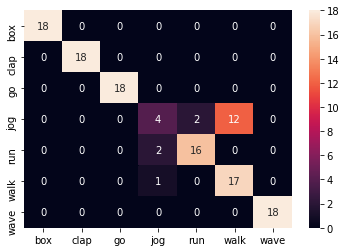

In [35]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'])